### Bayesian Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import cos_exp_square_nd,plot_line,x_sampler,acquisition_function,scale_to_match_range,\
    get_x_sub_kdpp,argmax_acquisition
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3)
print ("Packages Loaded.")

Packages Loaded.


In [2]:
def func_eval(x): # x:[n x d]
    y = cos_exp_square_nd(x)
    return y # y:[n x 1]

### Target Cost Function

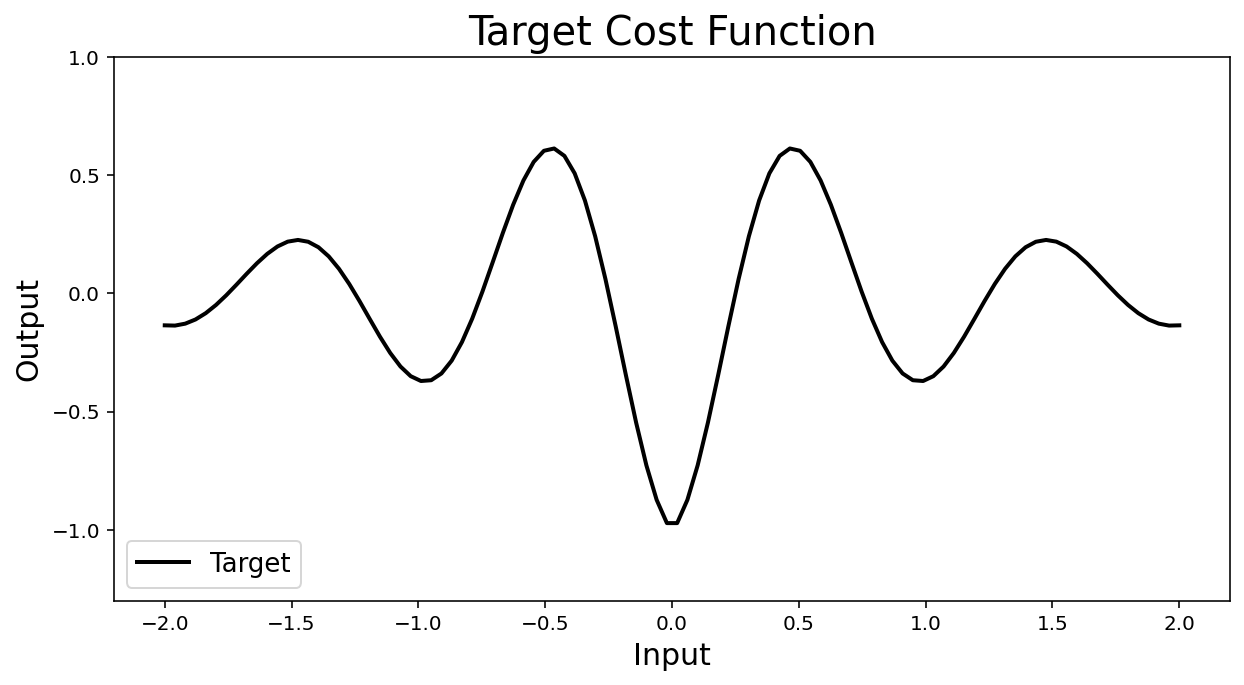

In [3]:
xmin,xmax = -2,2
x_target = np.linspace(start=xmin,stop=xmax,num=100).reshape((-1,1))
y_target = func_eval(x_target)
plot_line(
    x_target,y_target,fmt='-',lc='k',lw=2,label='Target',
    figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Target Cost Function',tfs=20,
    ylim=[-1.3,+1],
    lfs=13,lloc='lower left')

### Bayesian Optimization

In [4]:
seed,x_minmax = 1,np.array([[xmin,xmax]])
max_step = 20

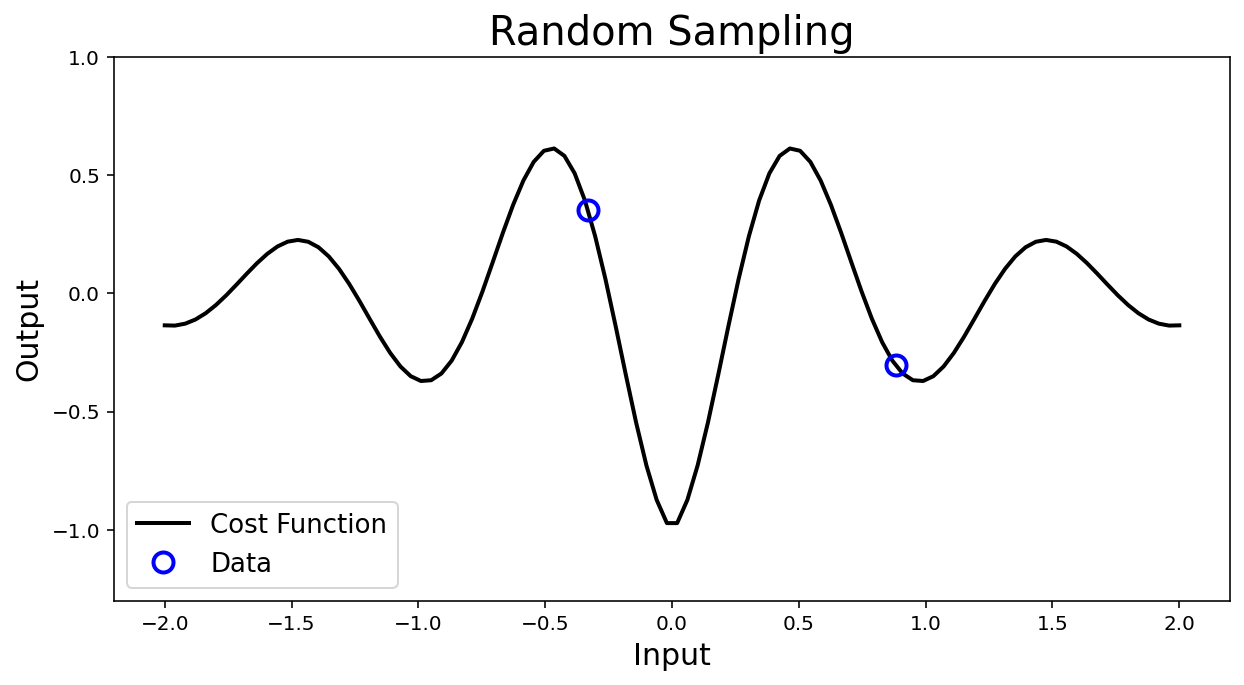

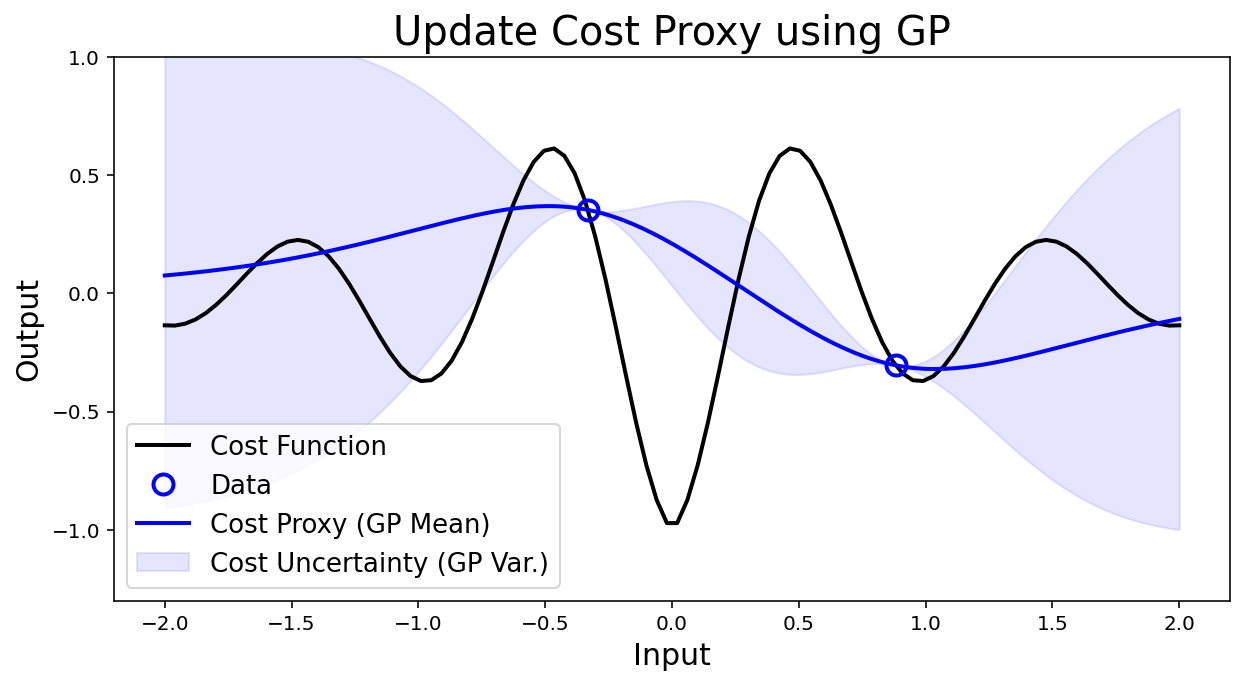

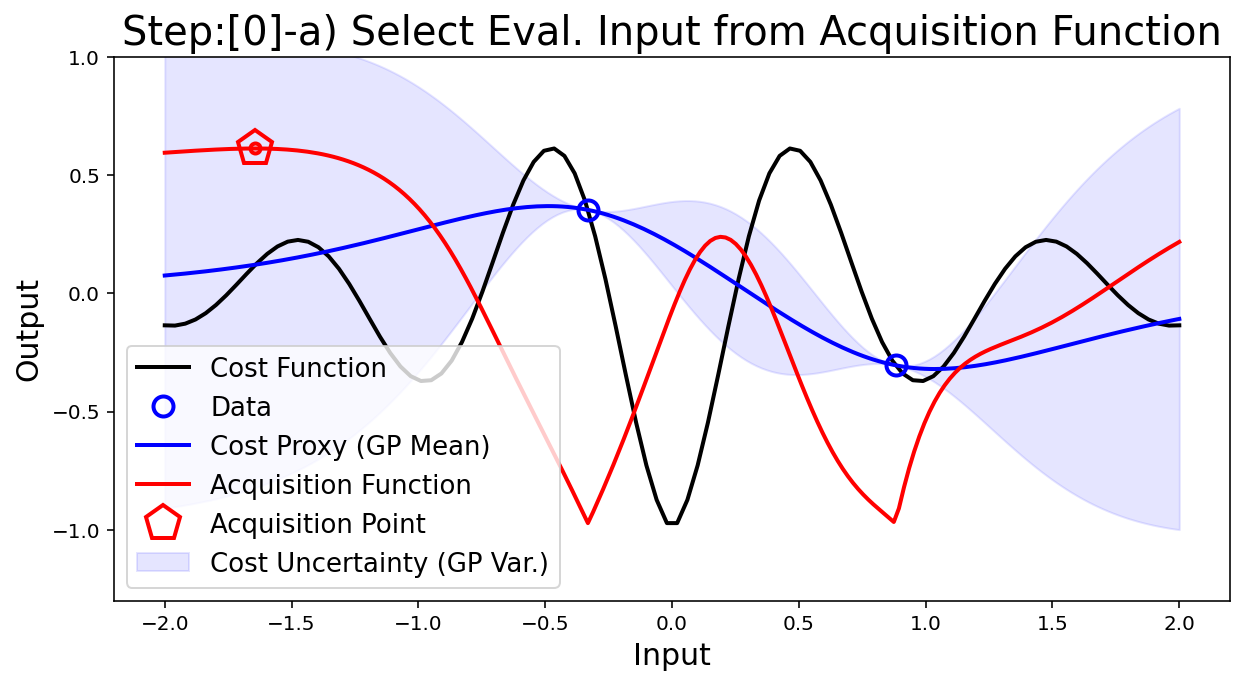

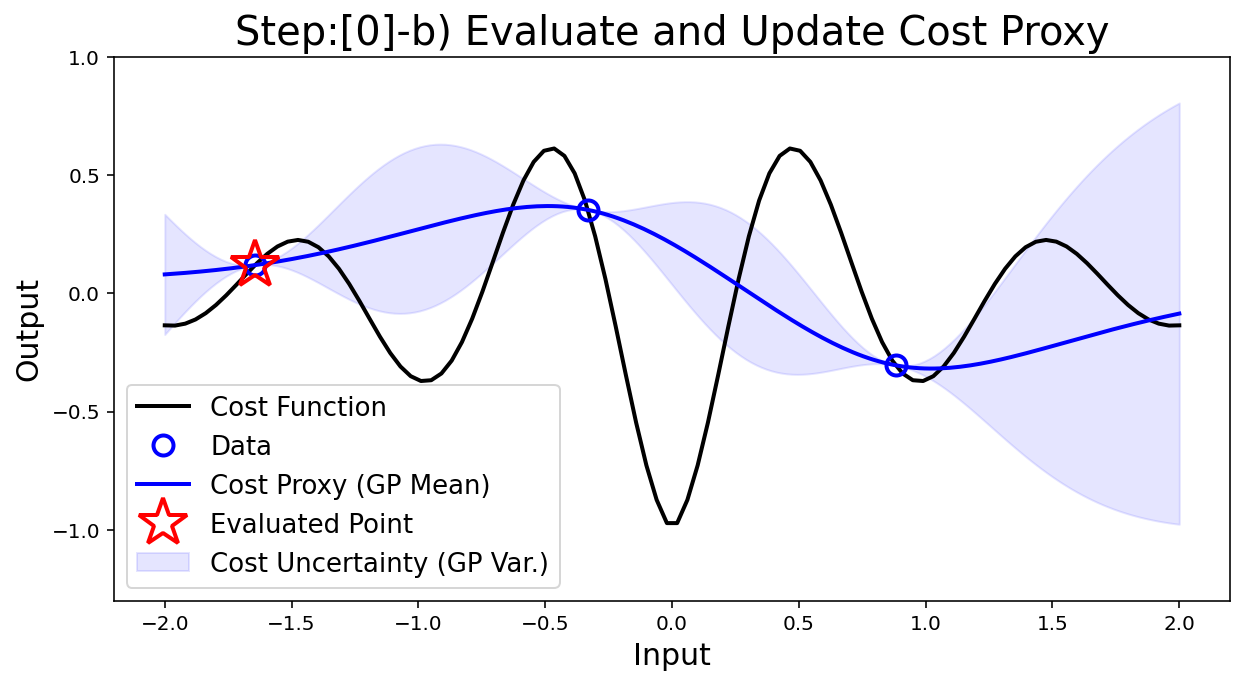

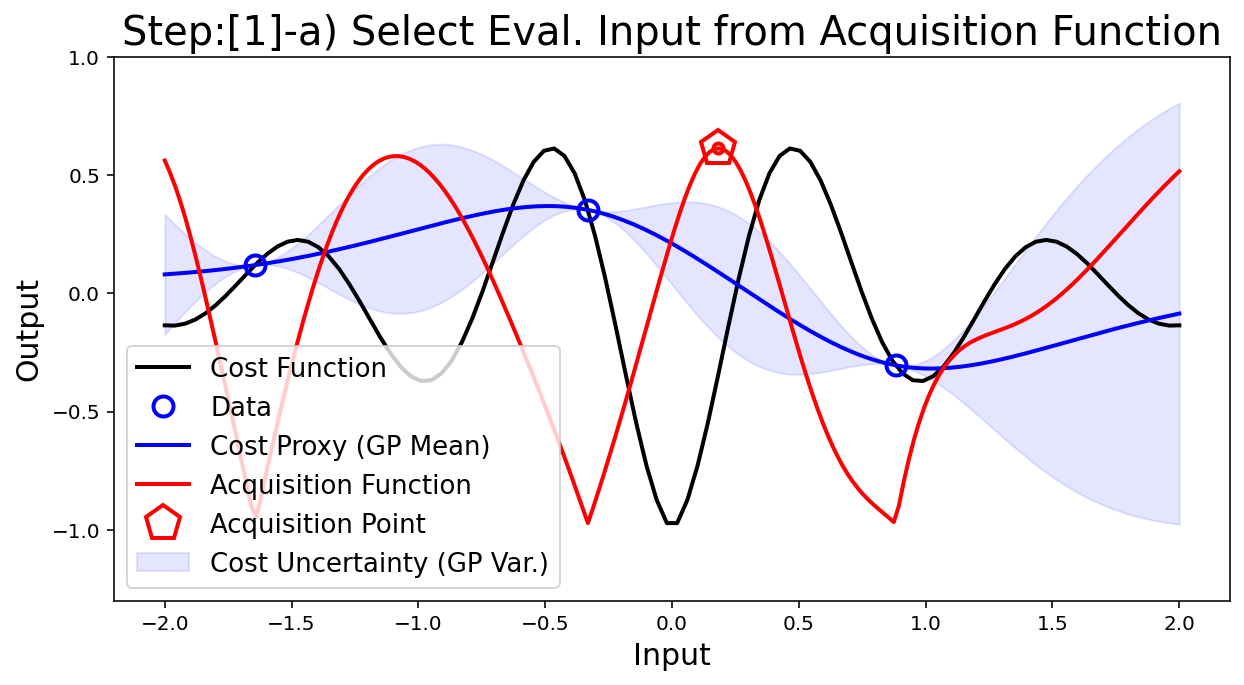

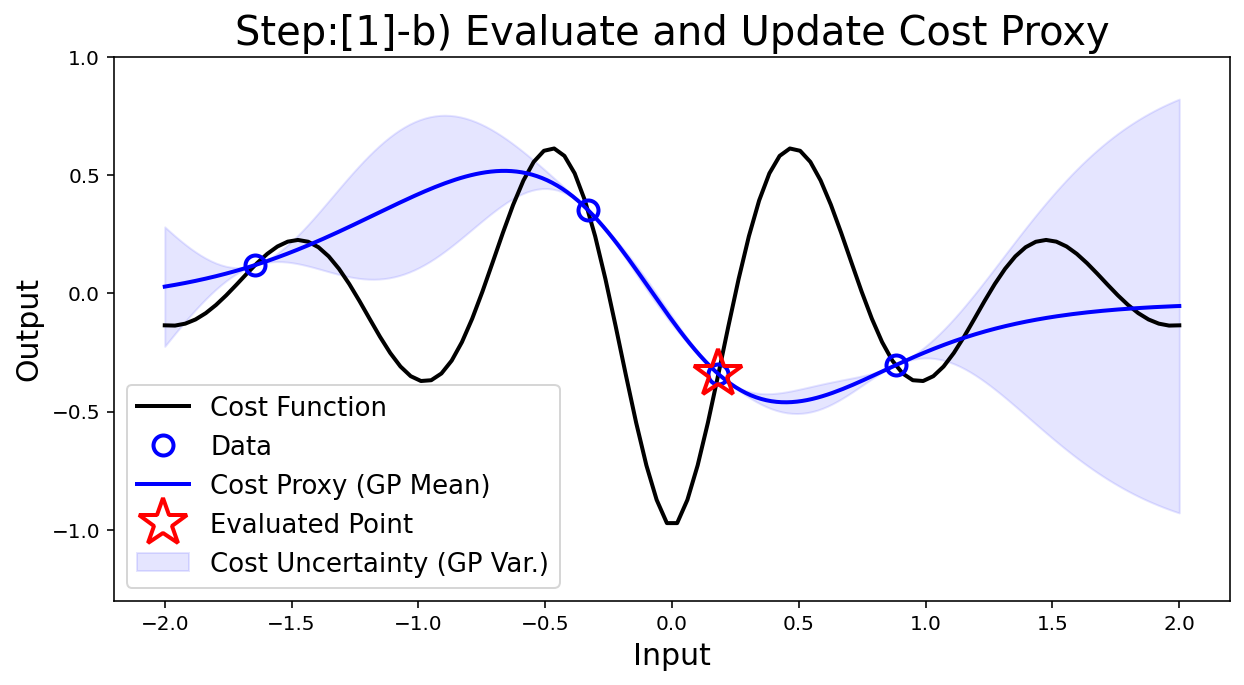

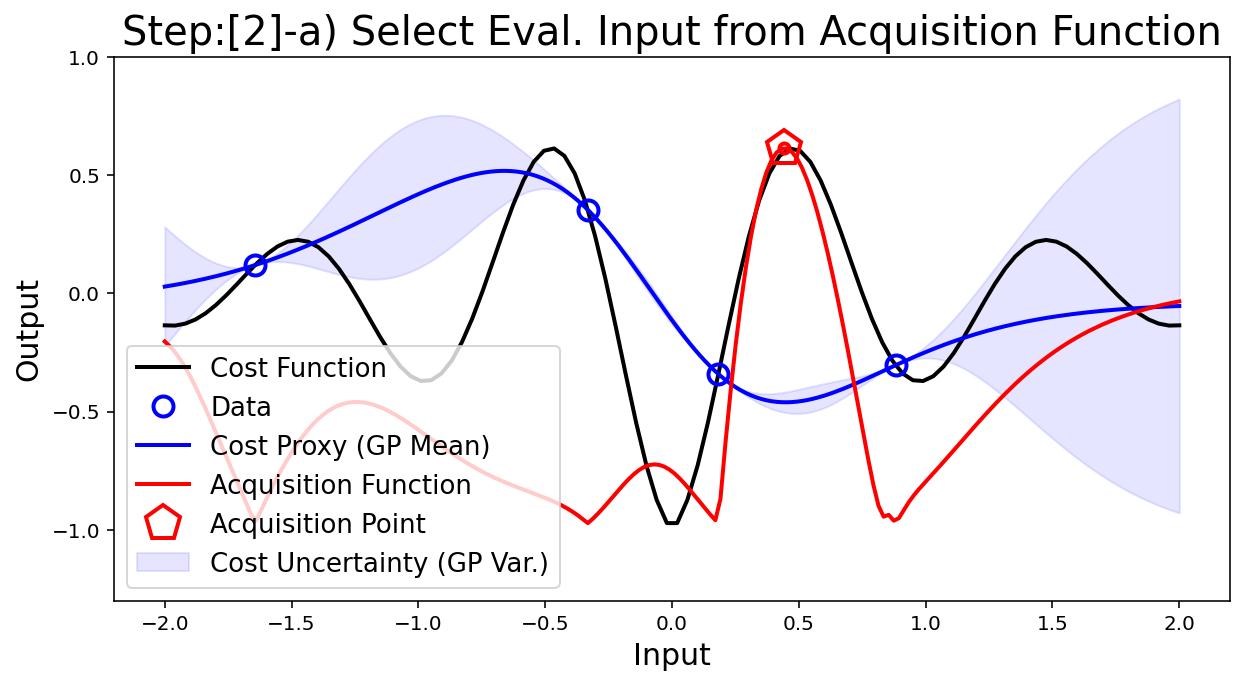

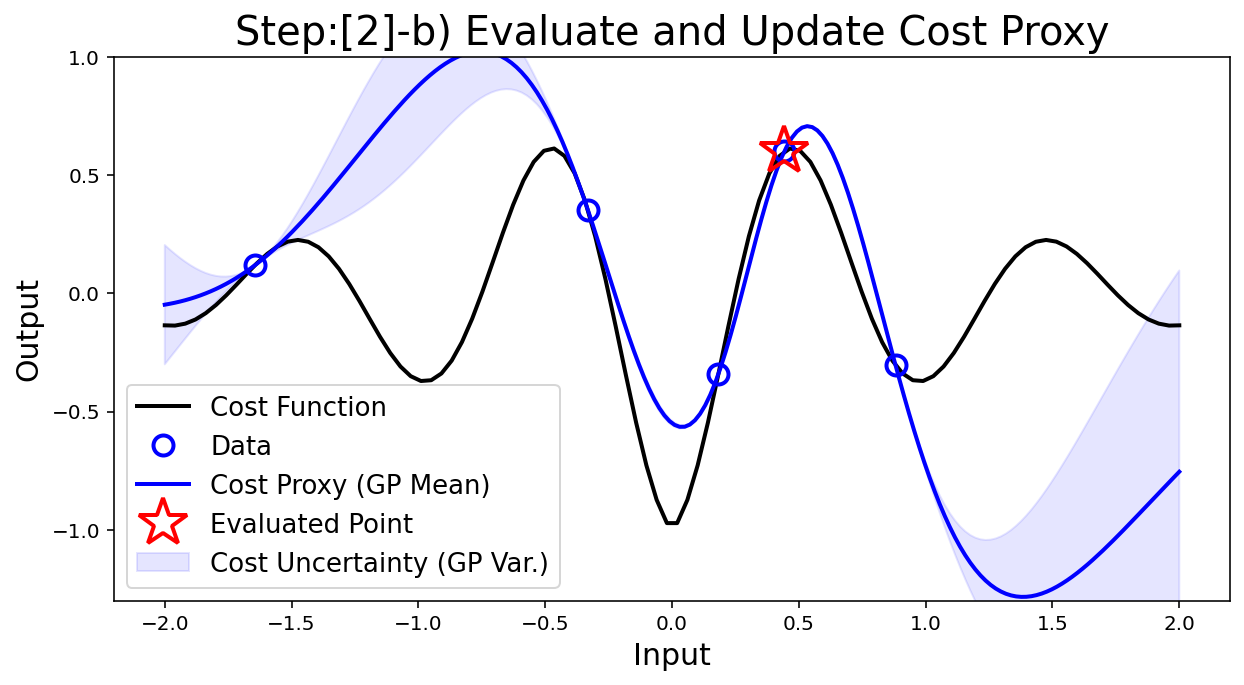

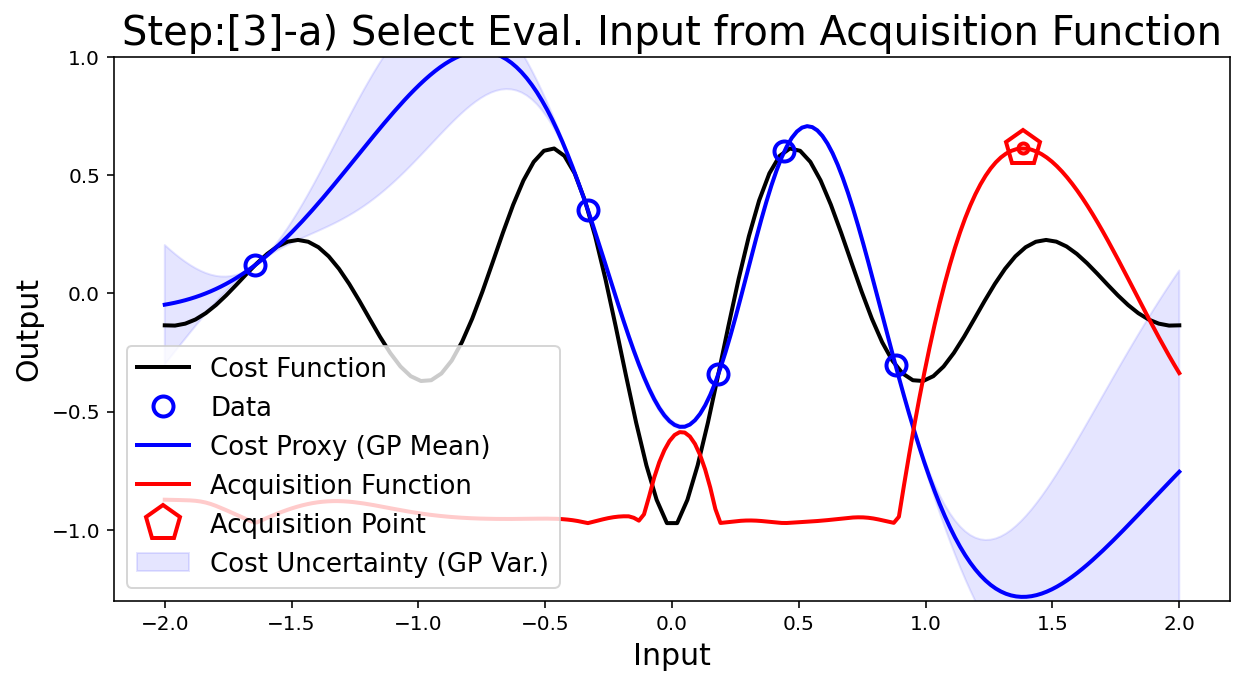

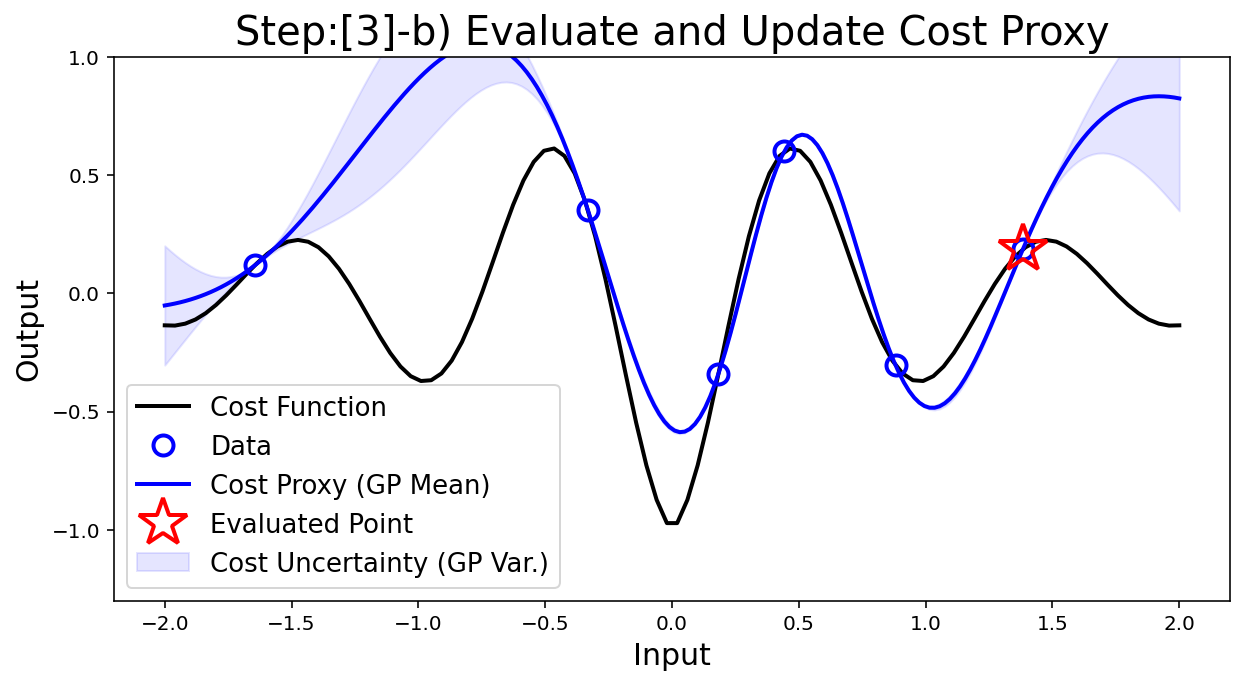

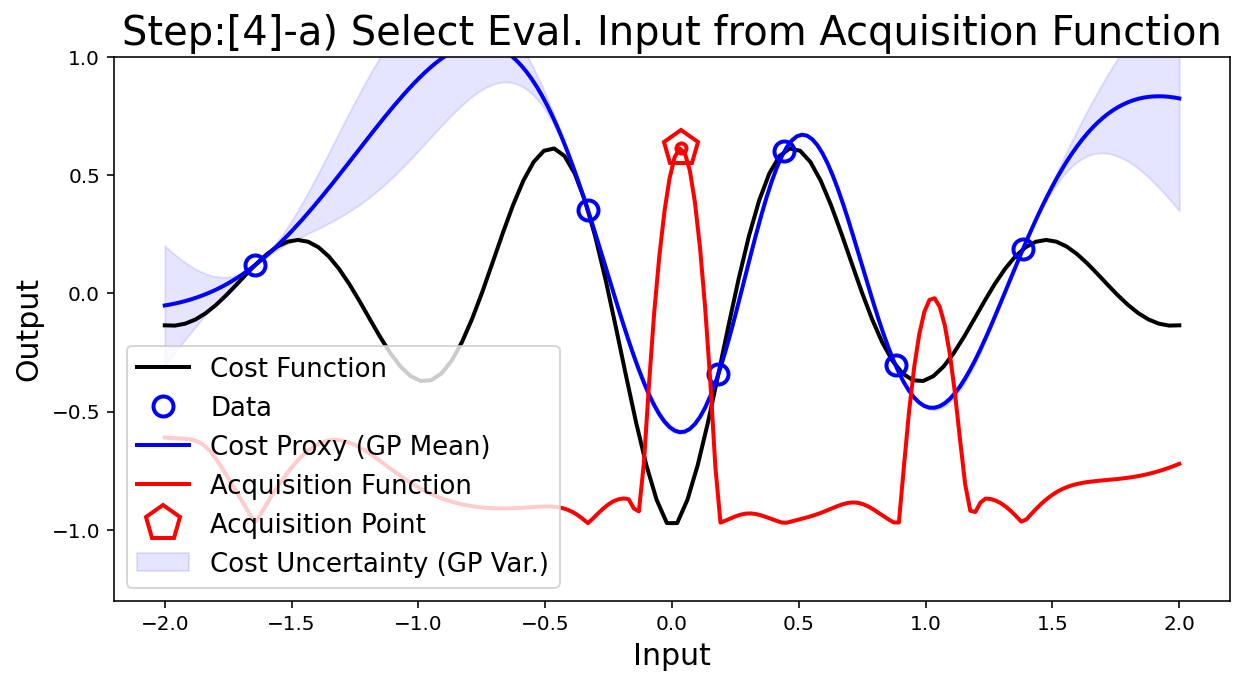

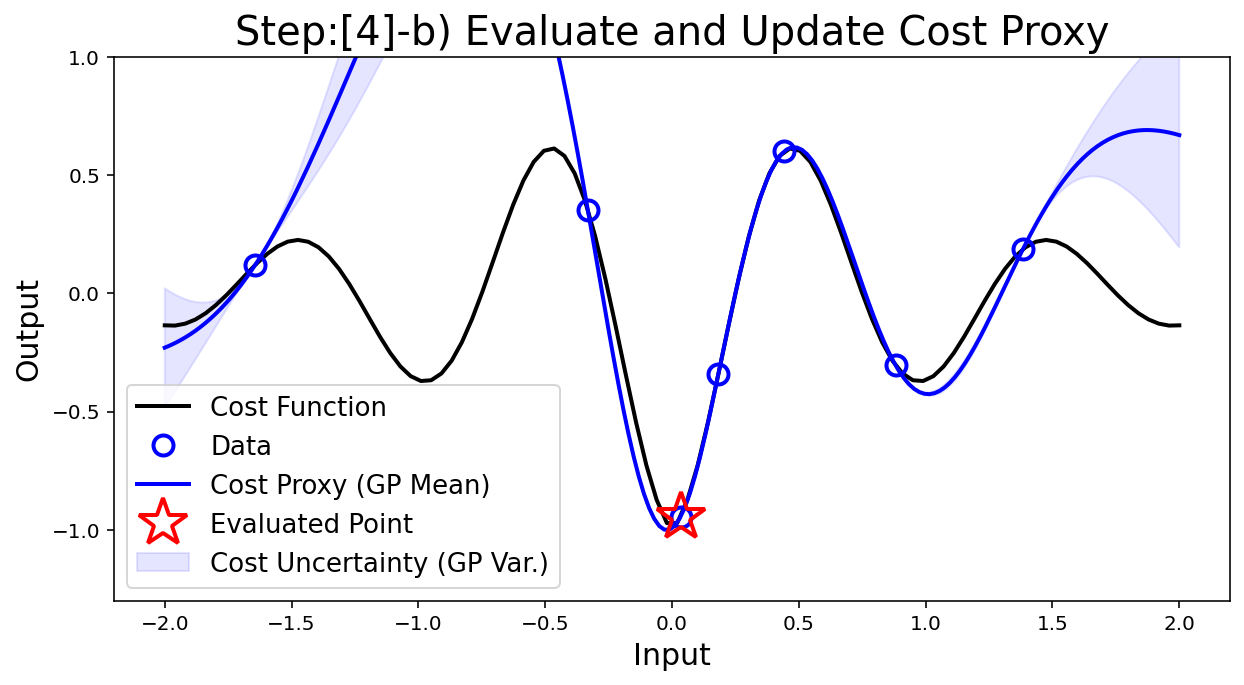

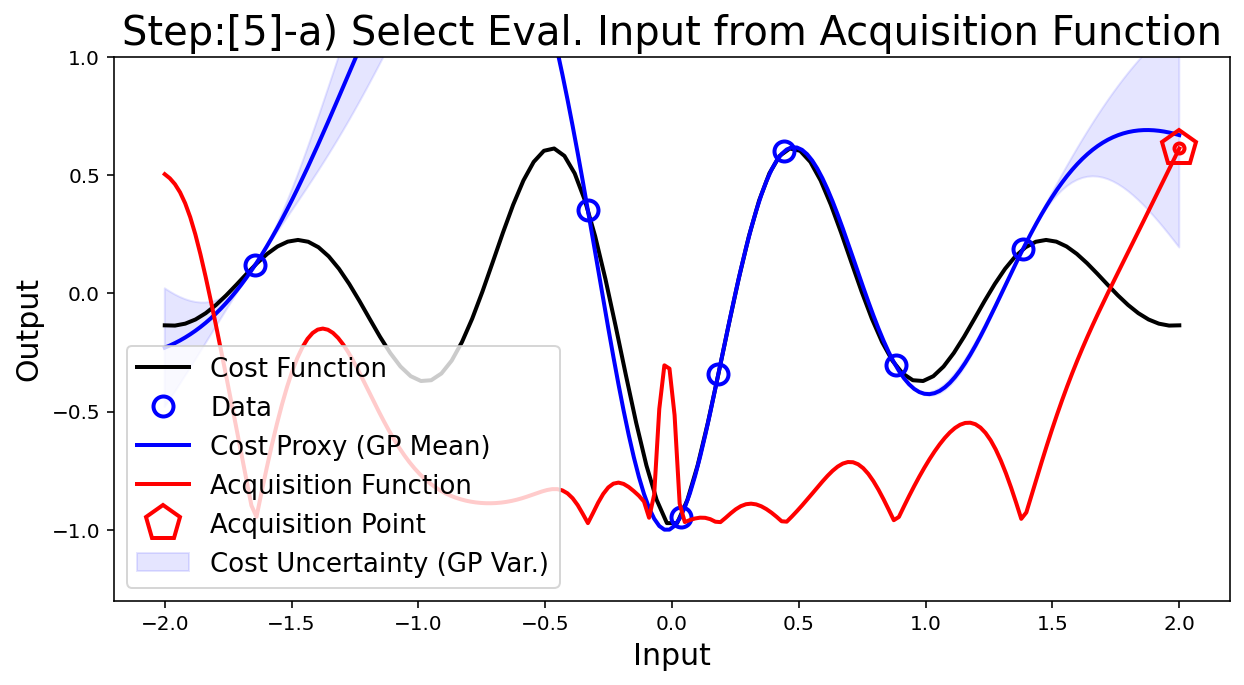

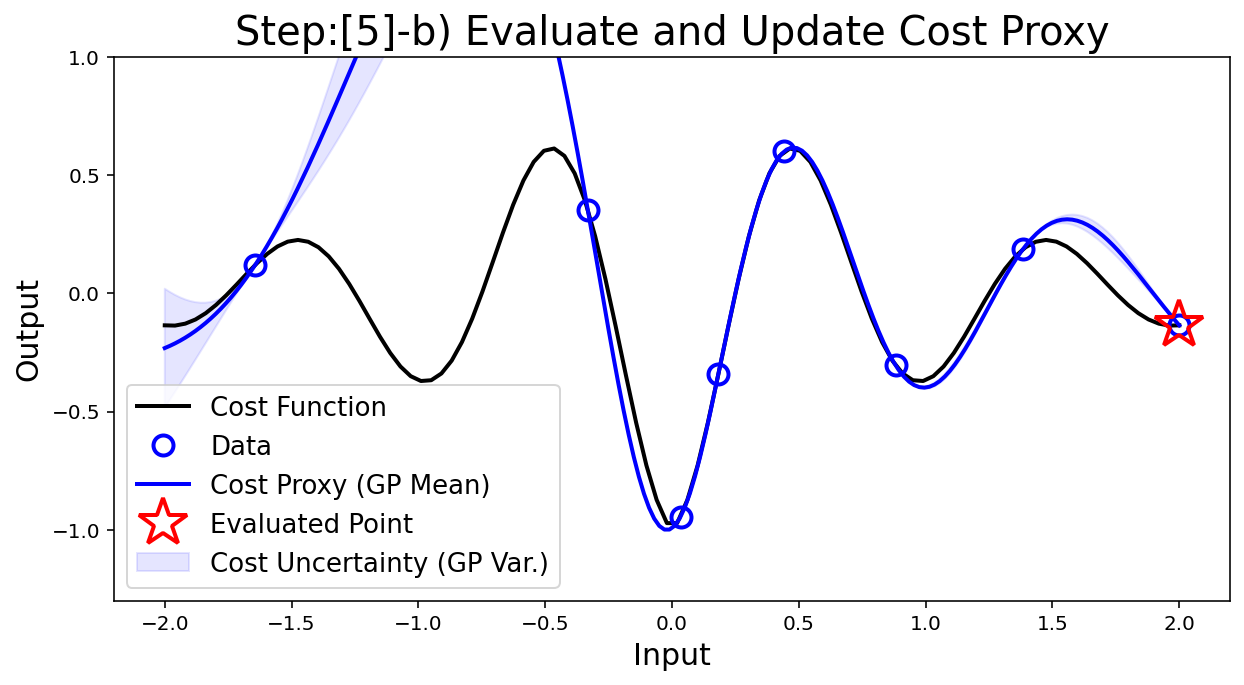

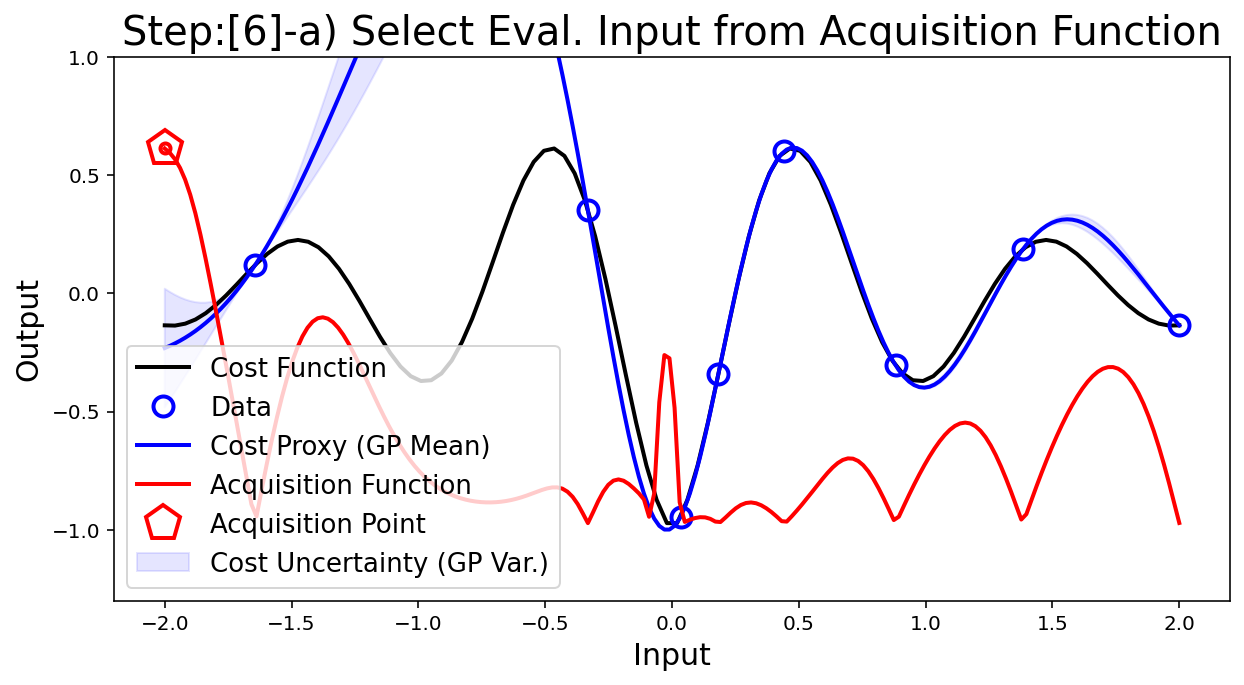

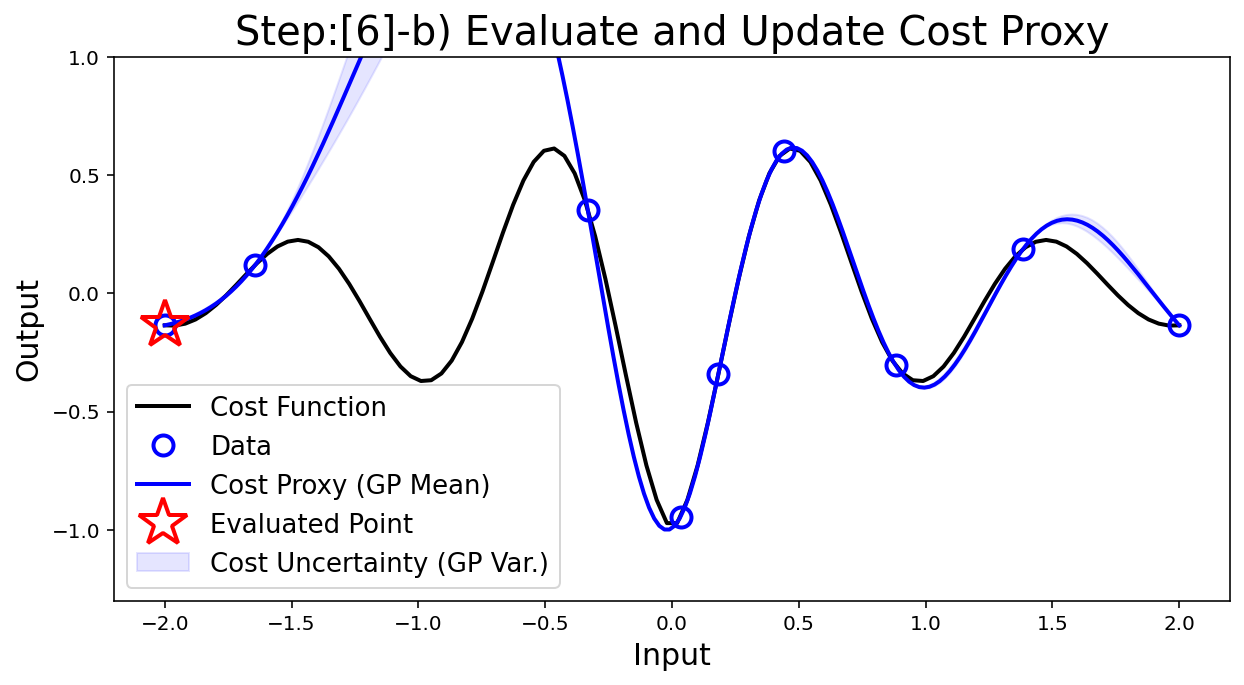

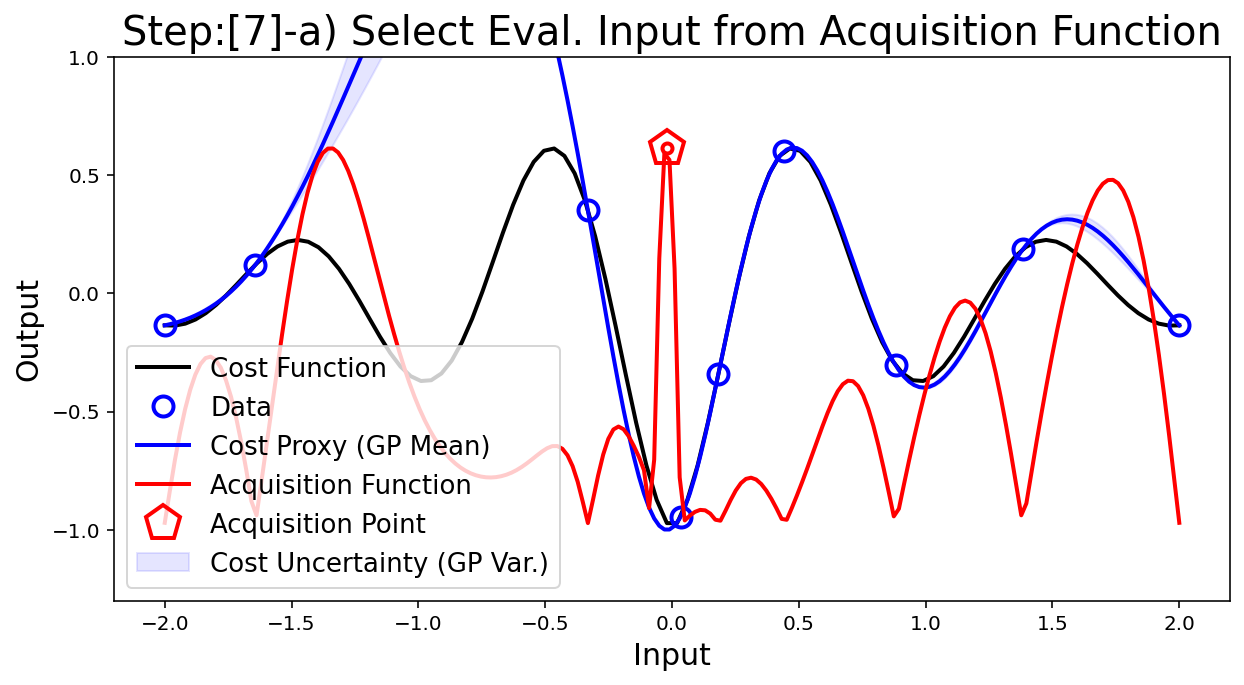

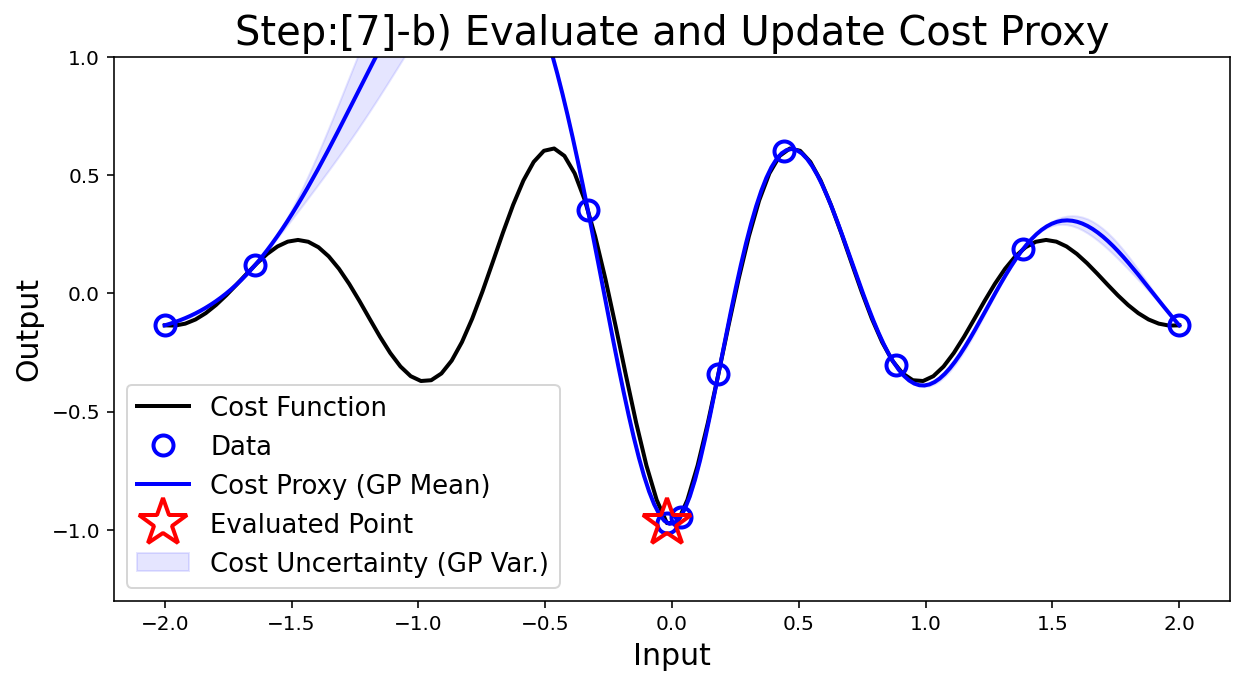

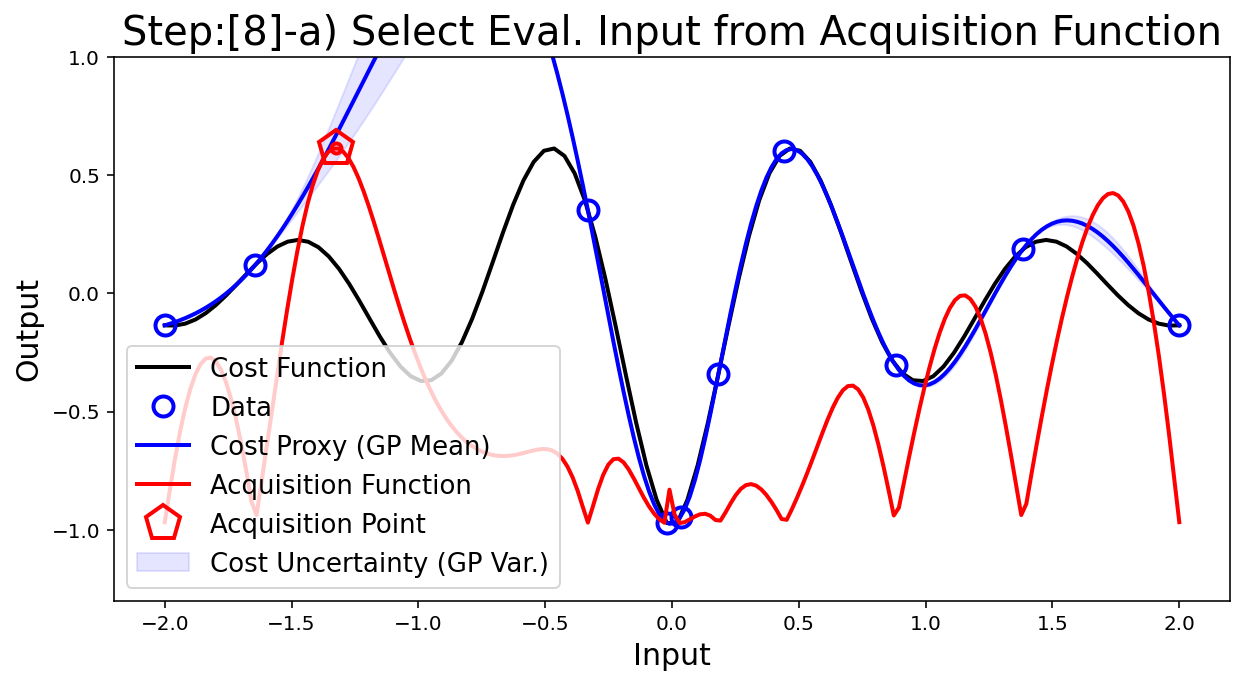

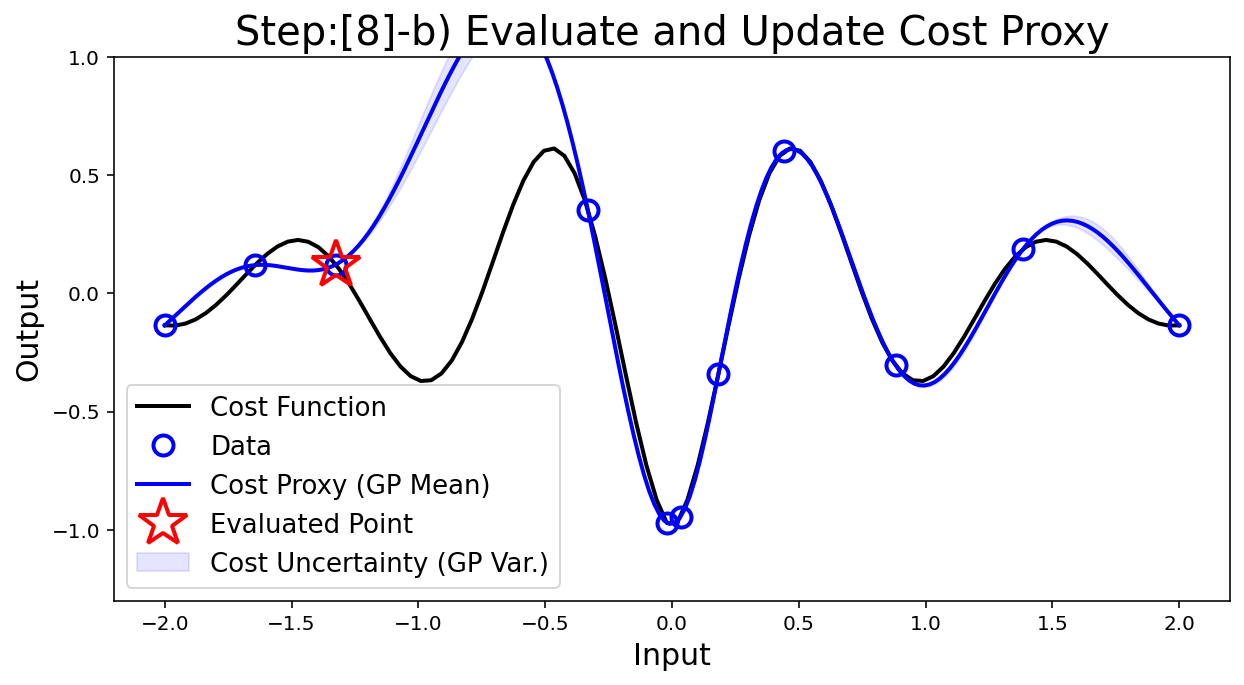

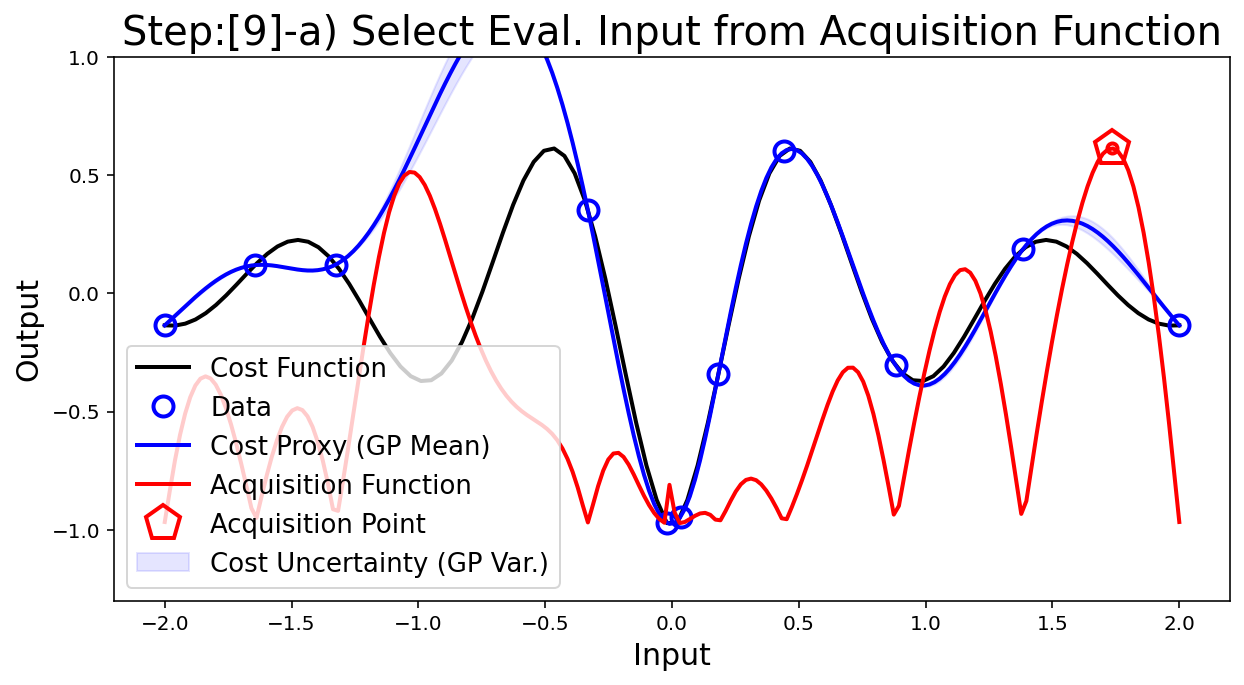

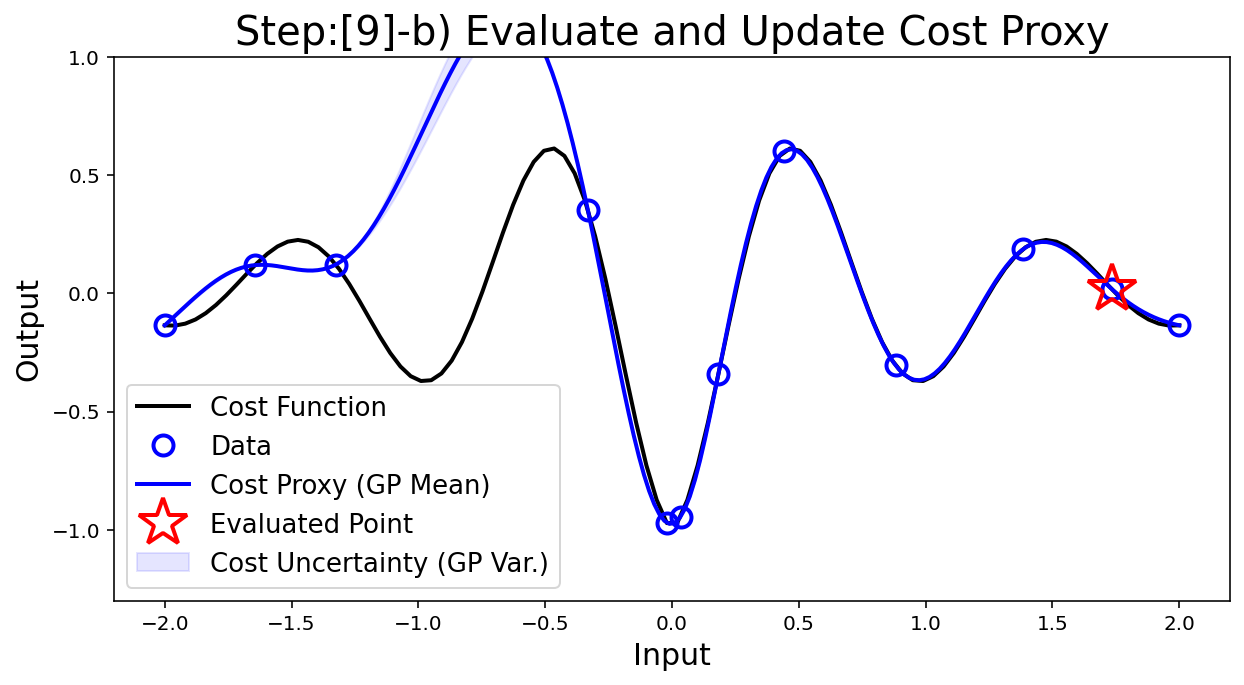

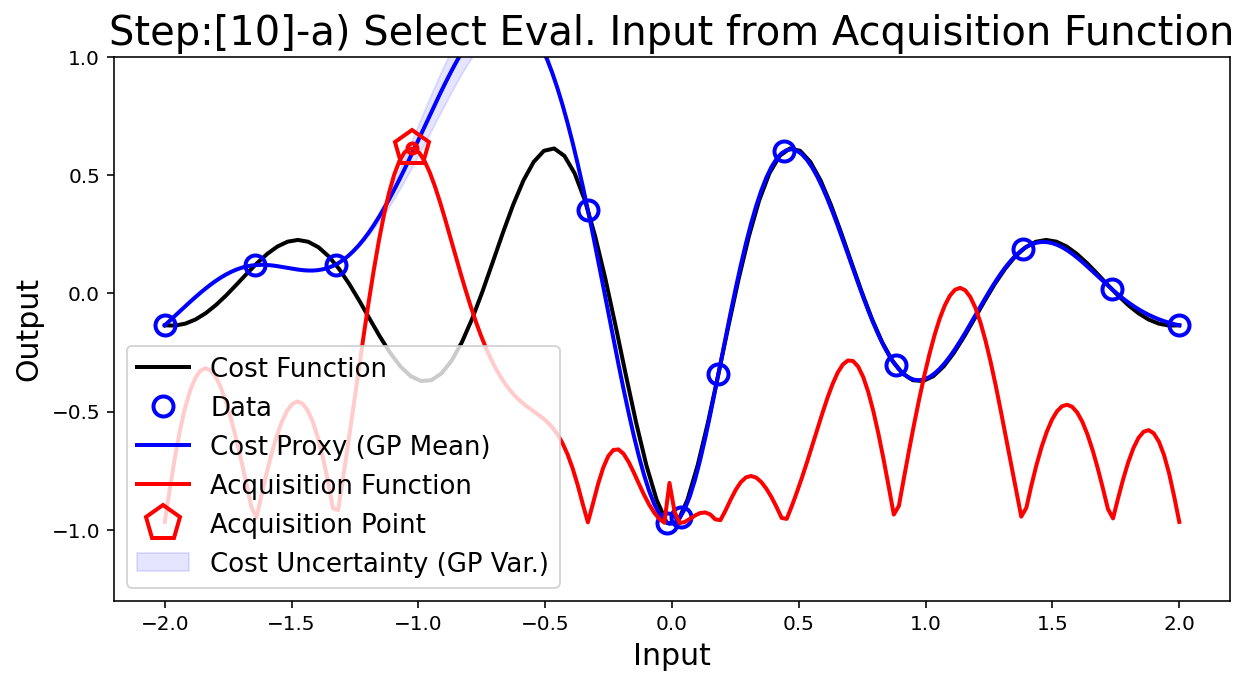

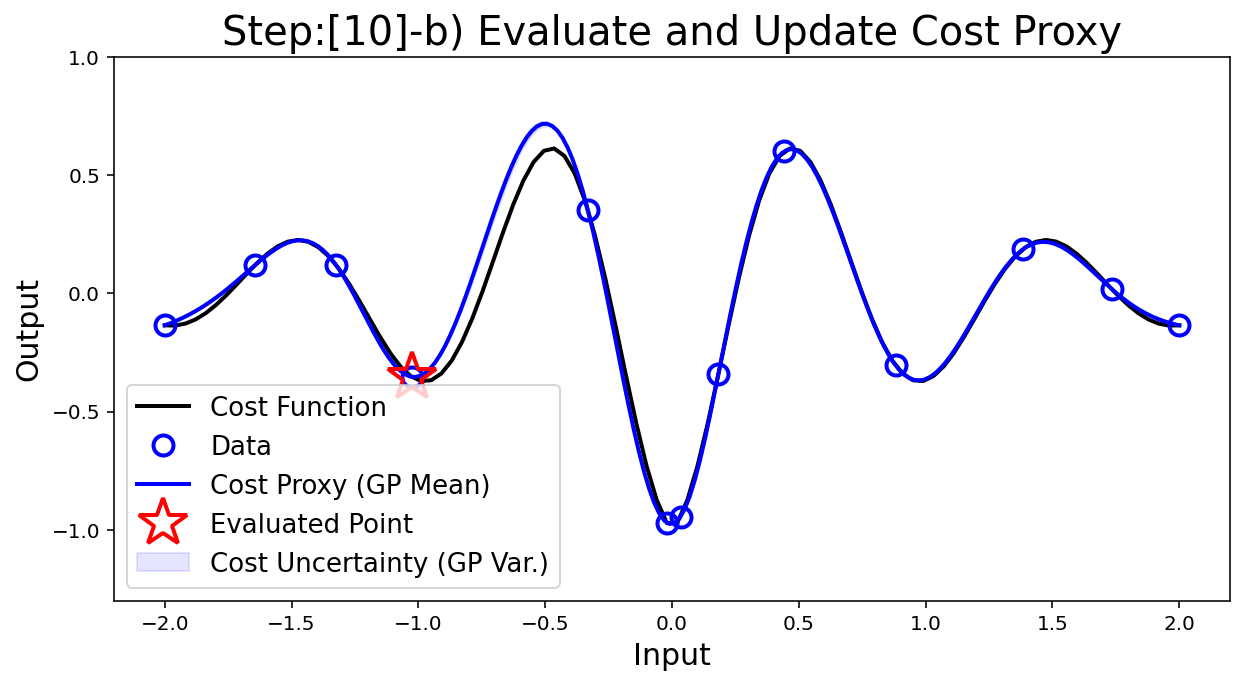

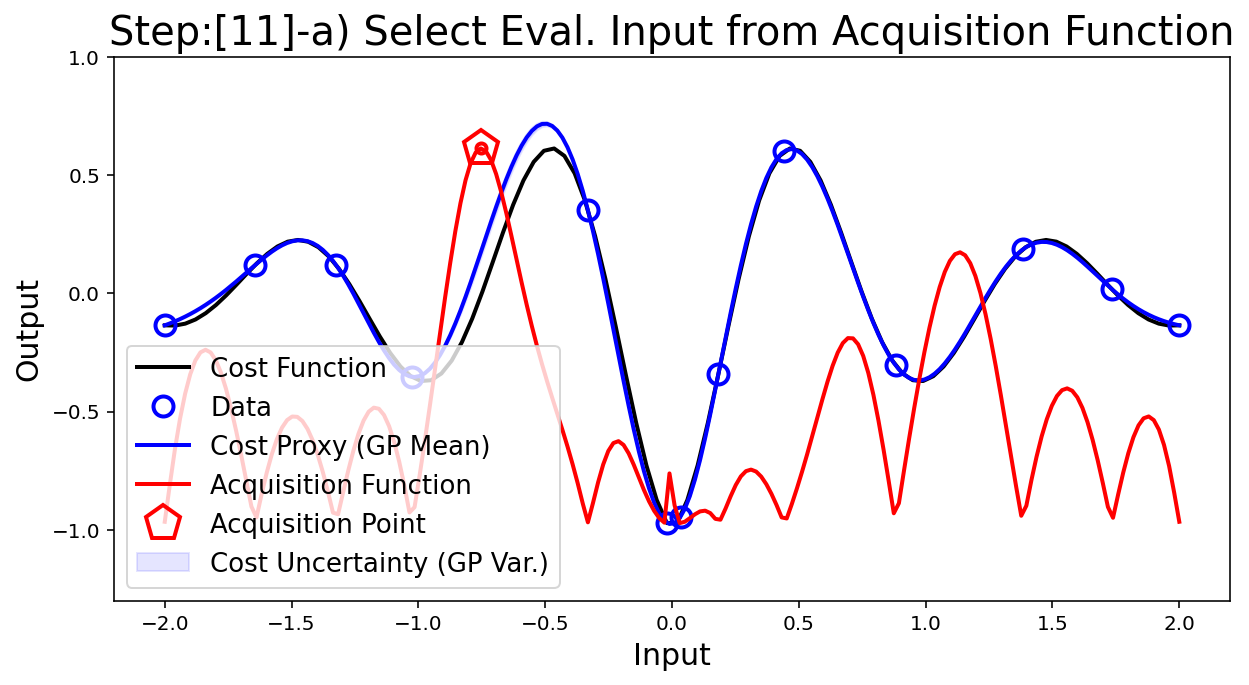

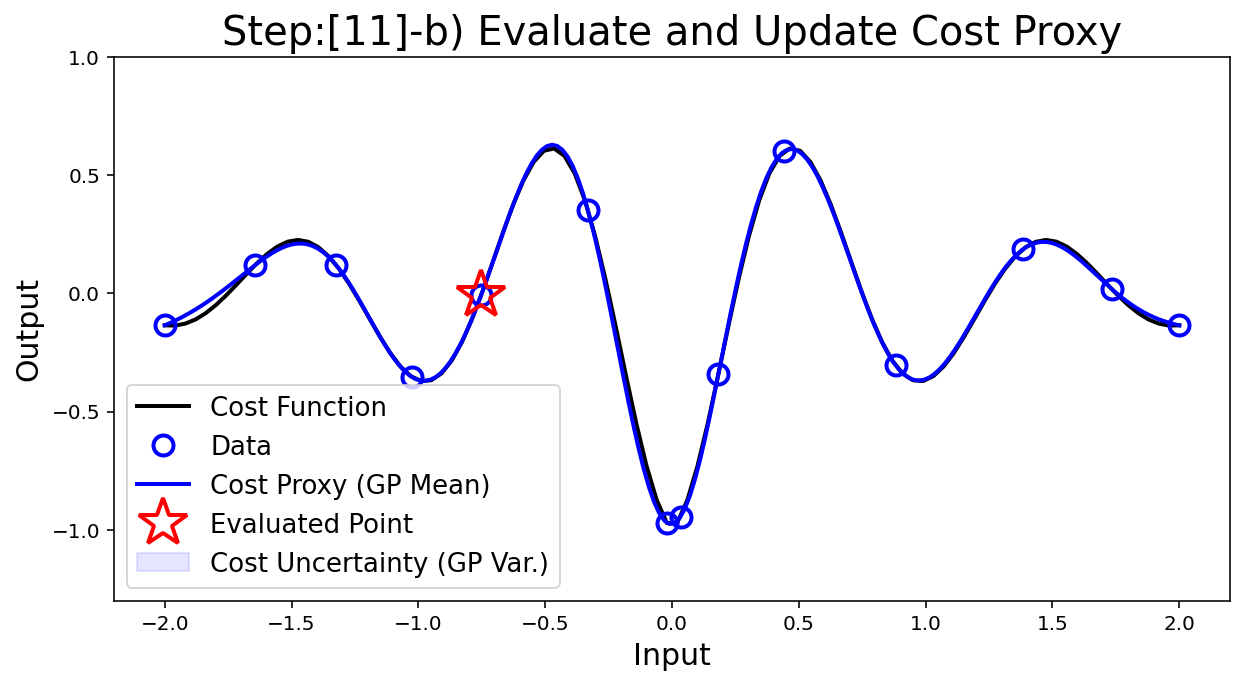

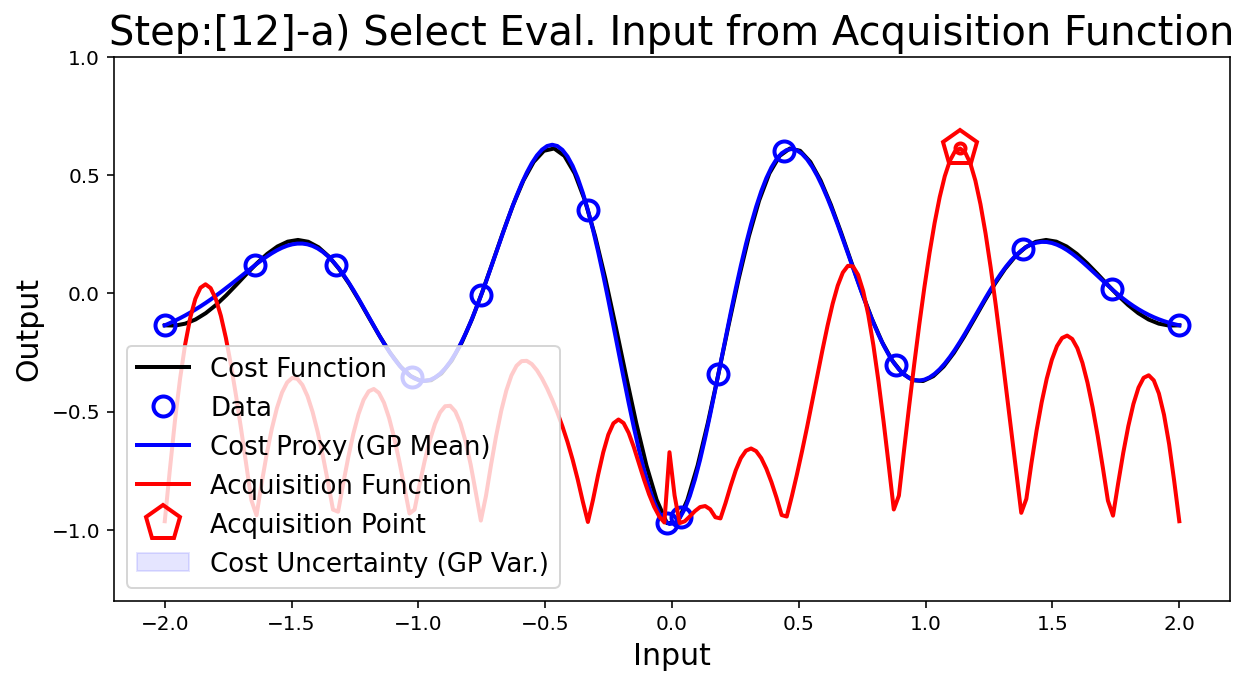

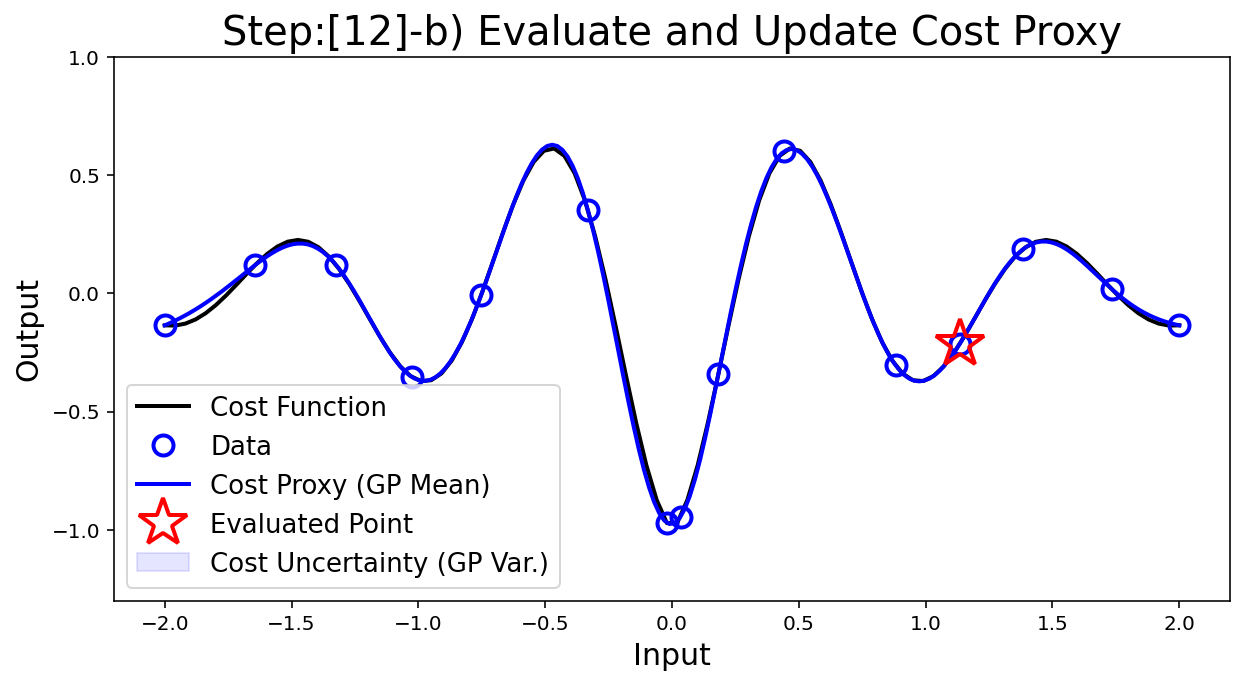

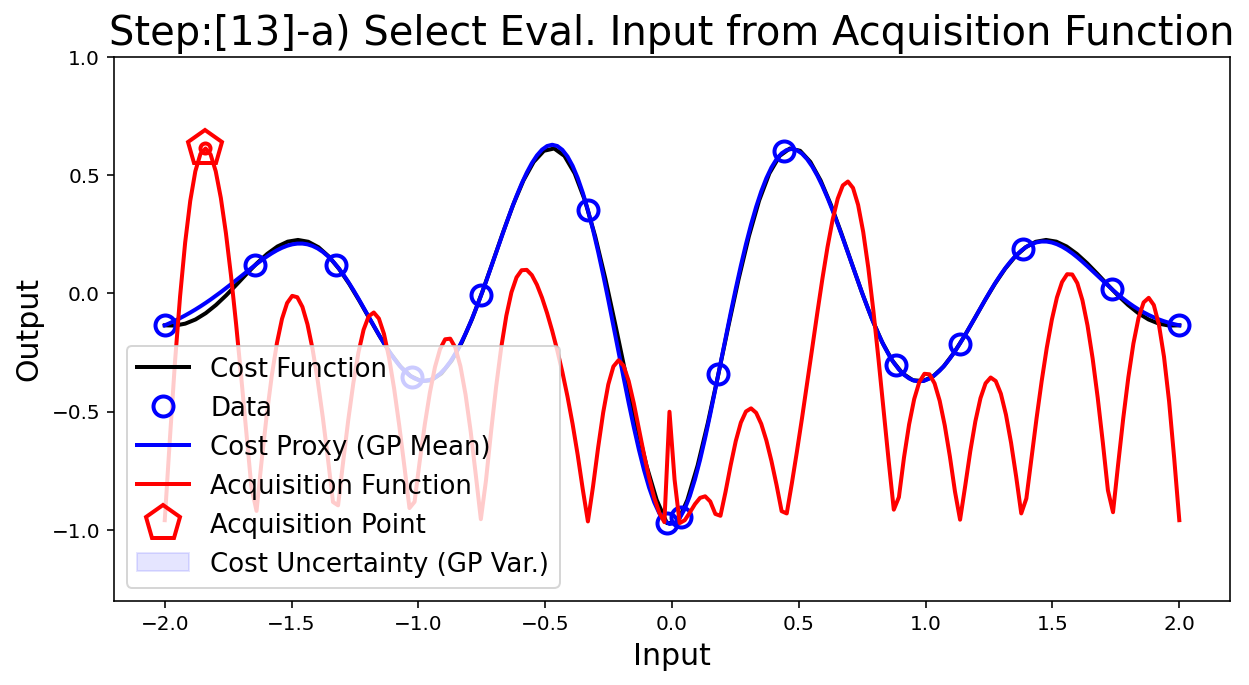

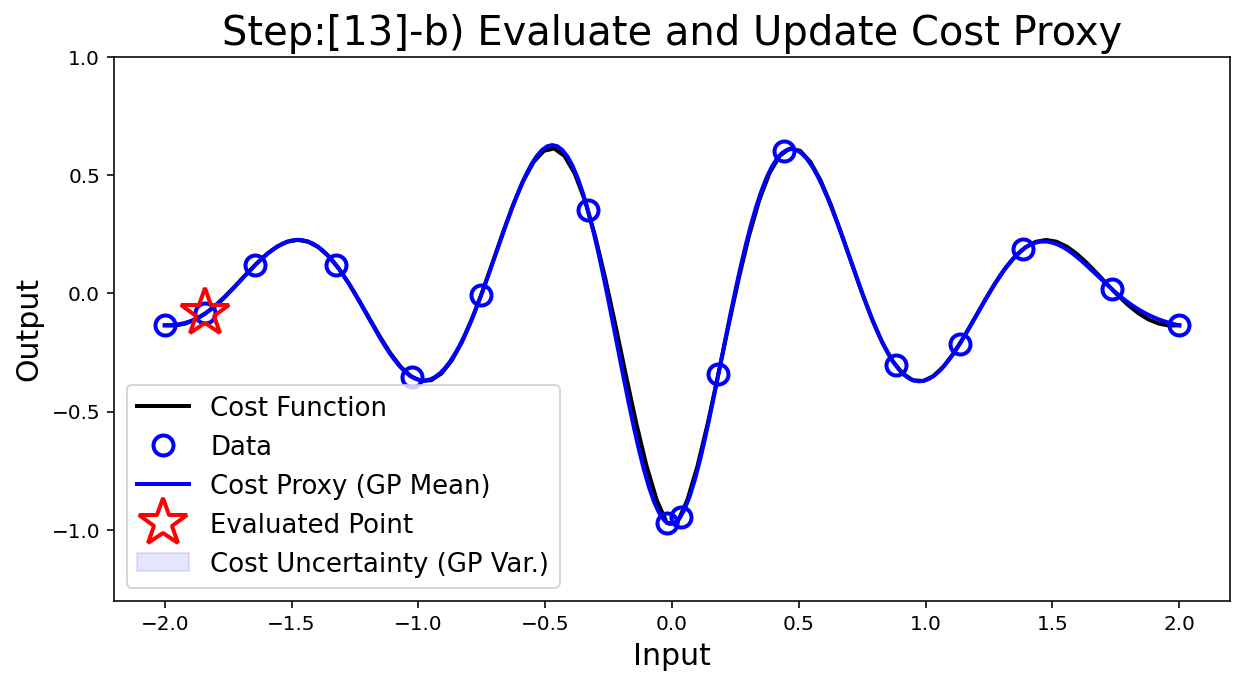

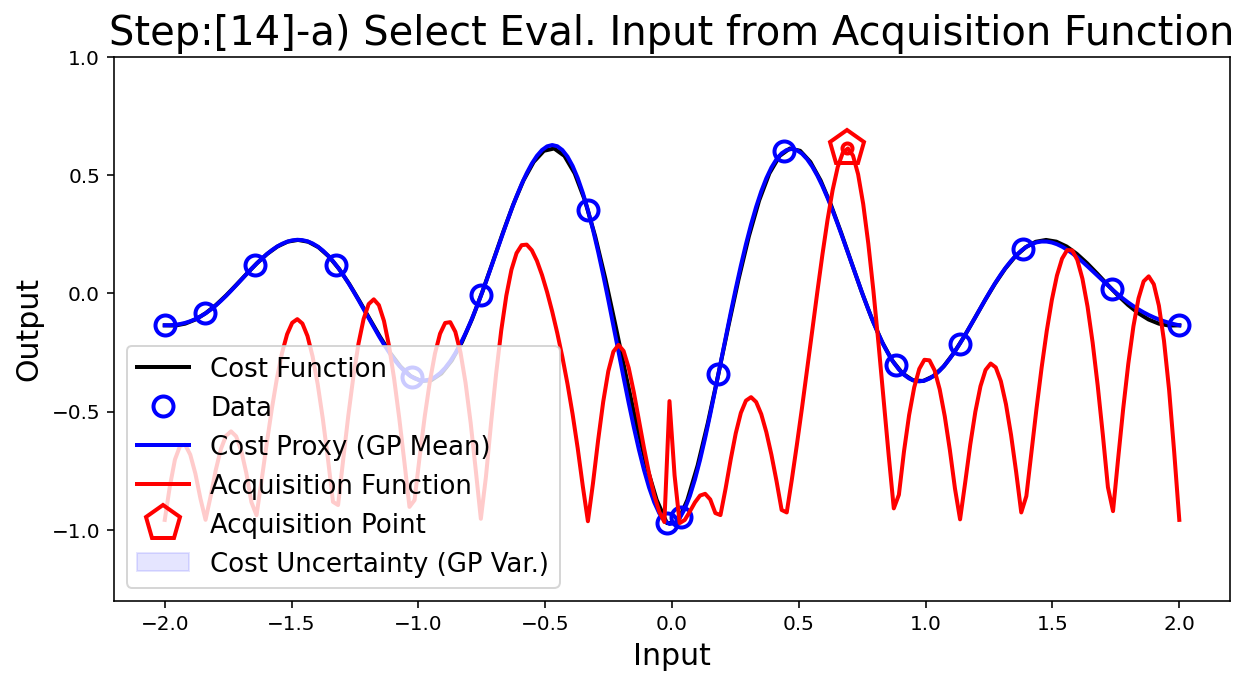

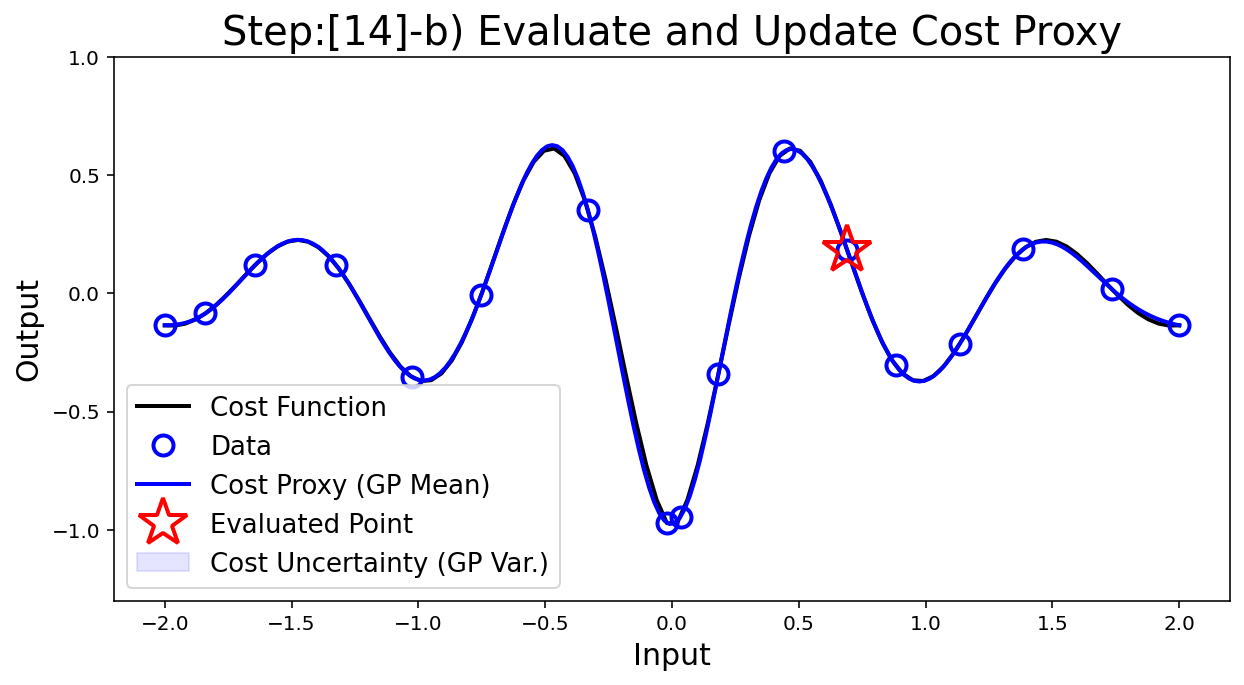

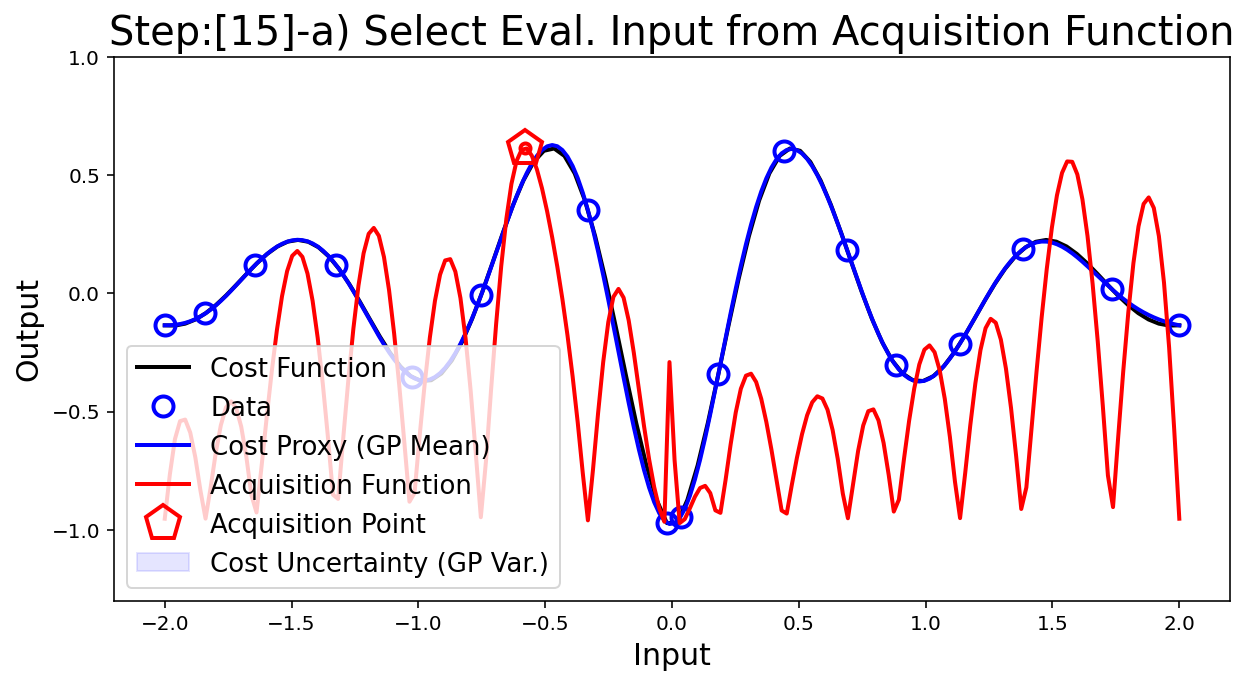

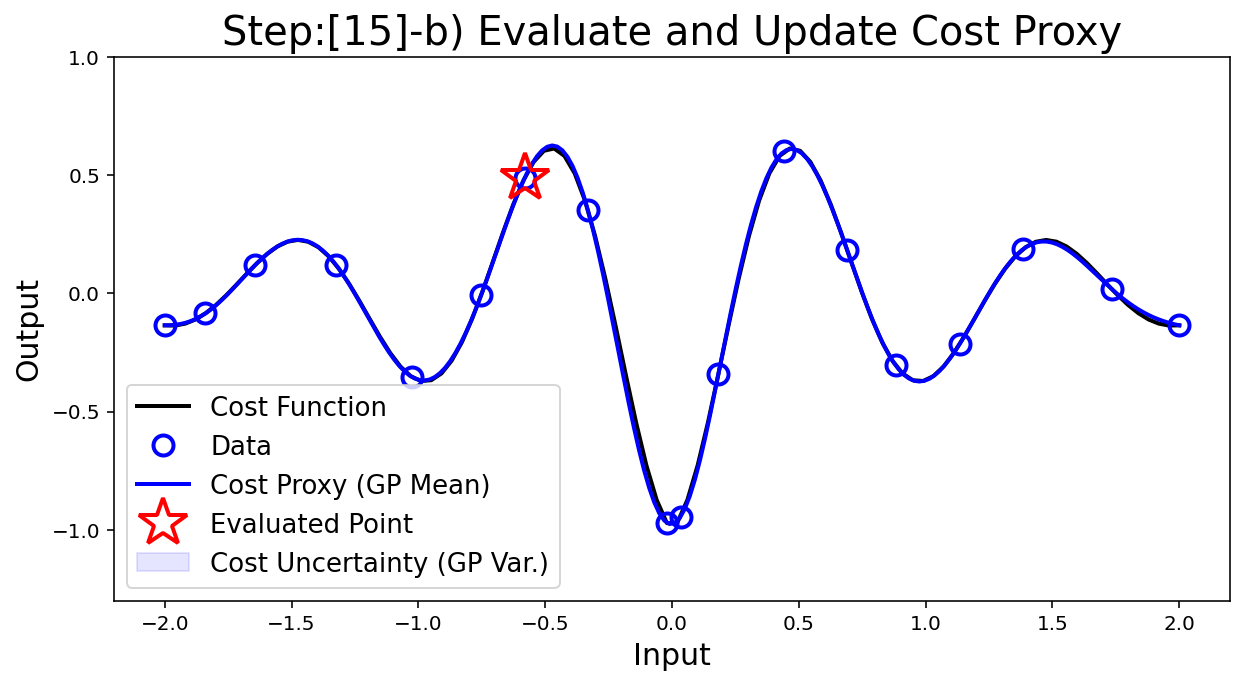

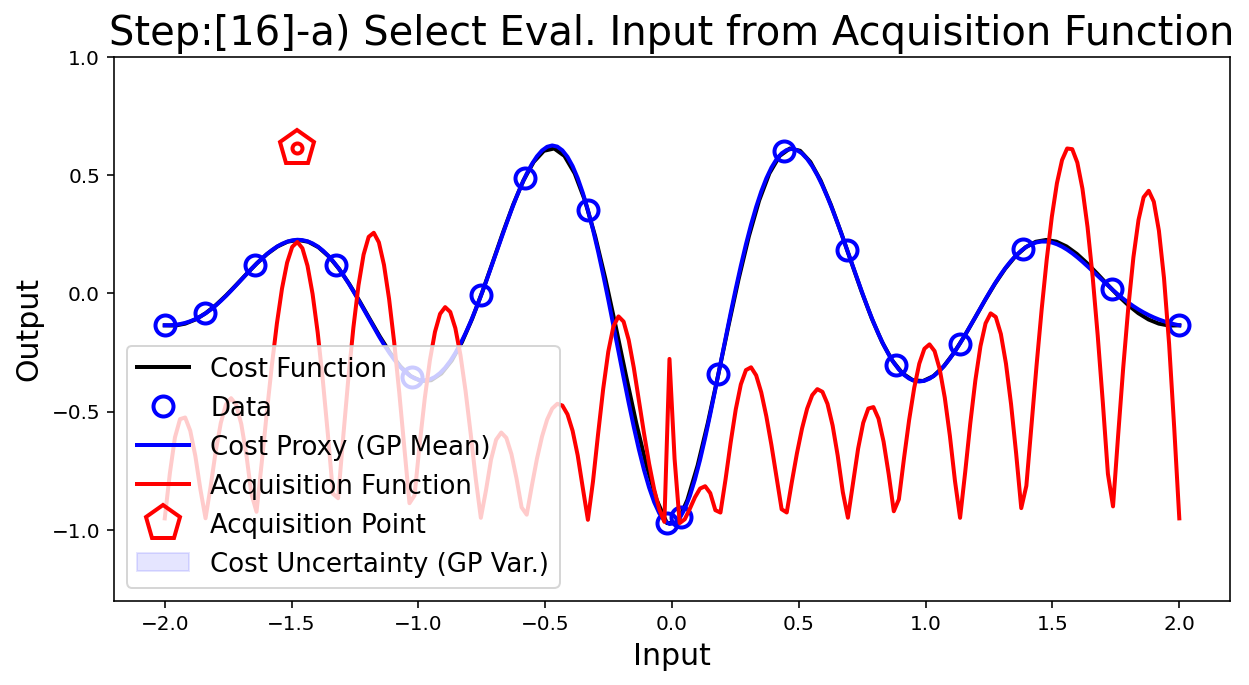

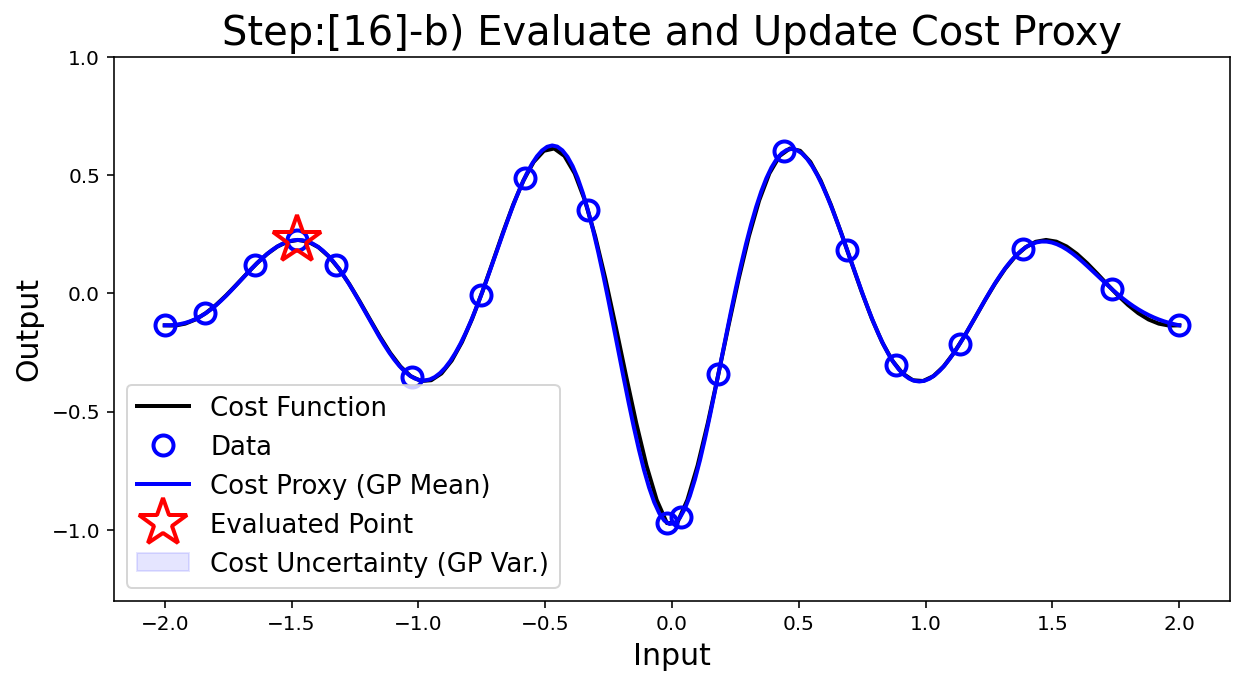

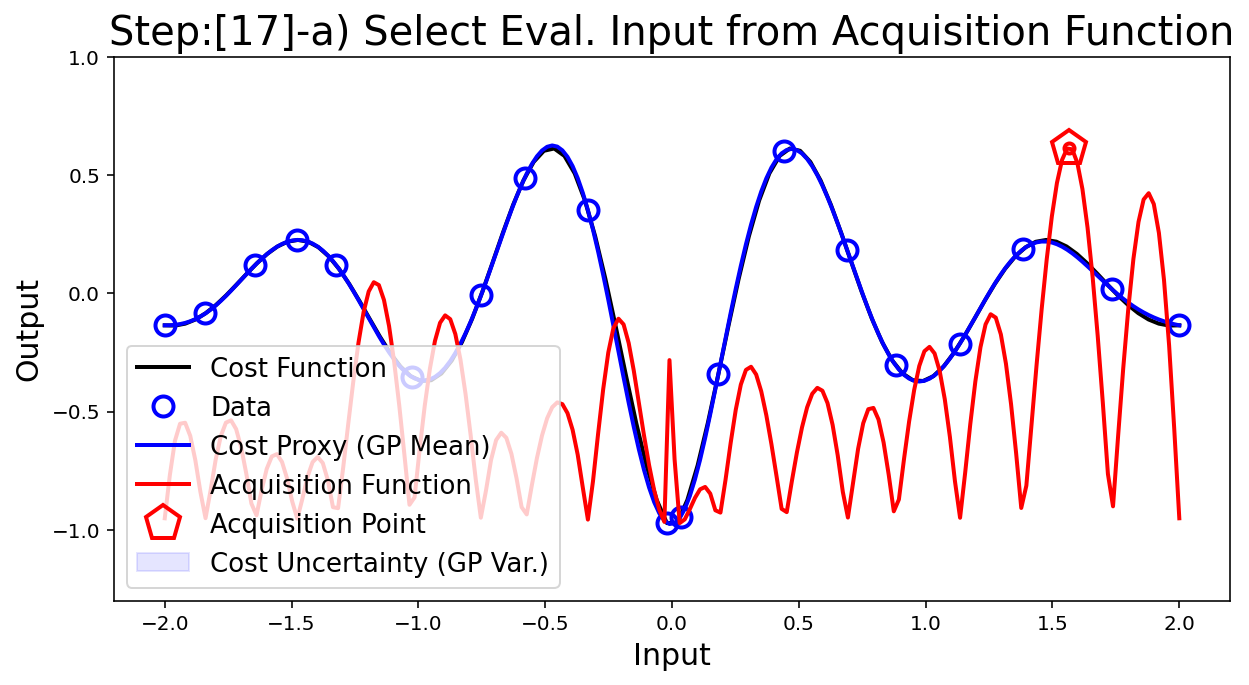

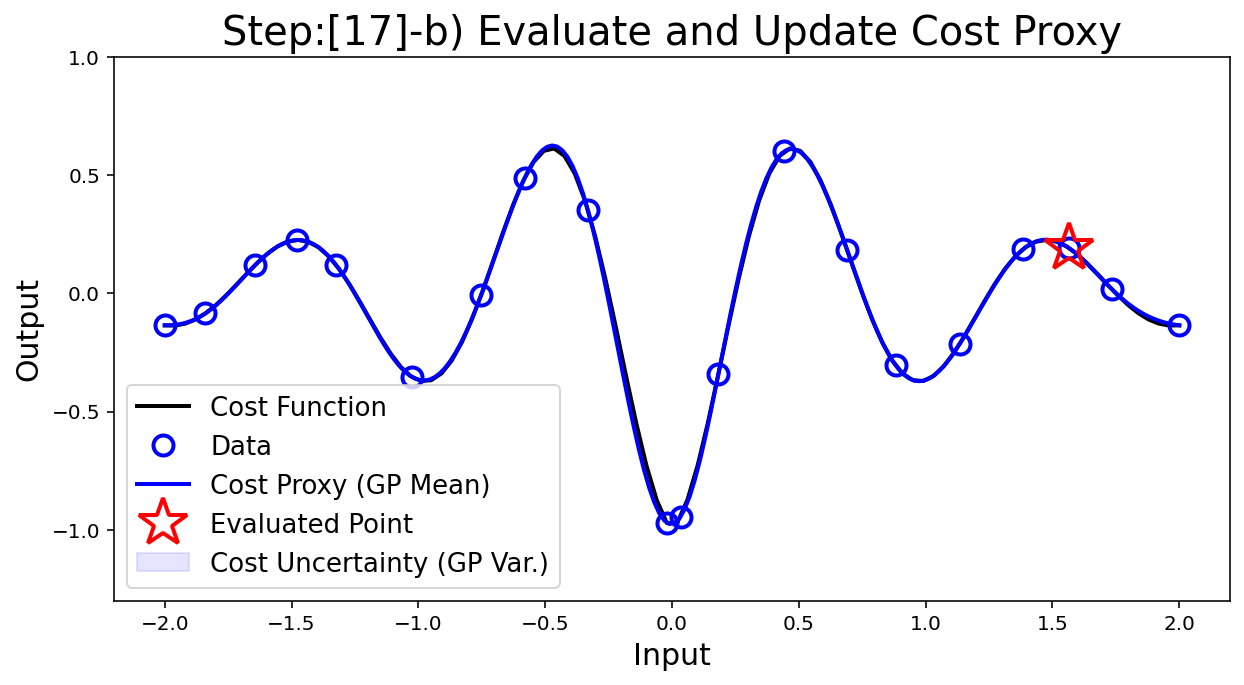

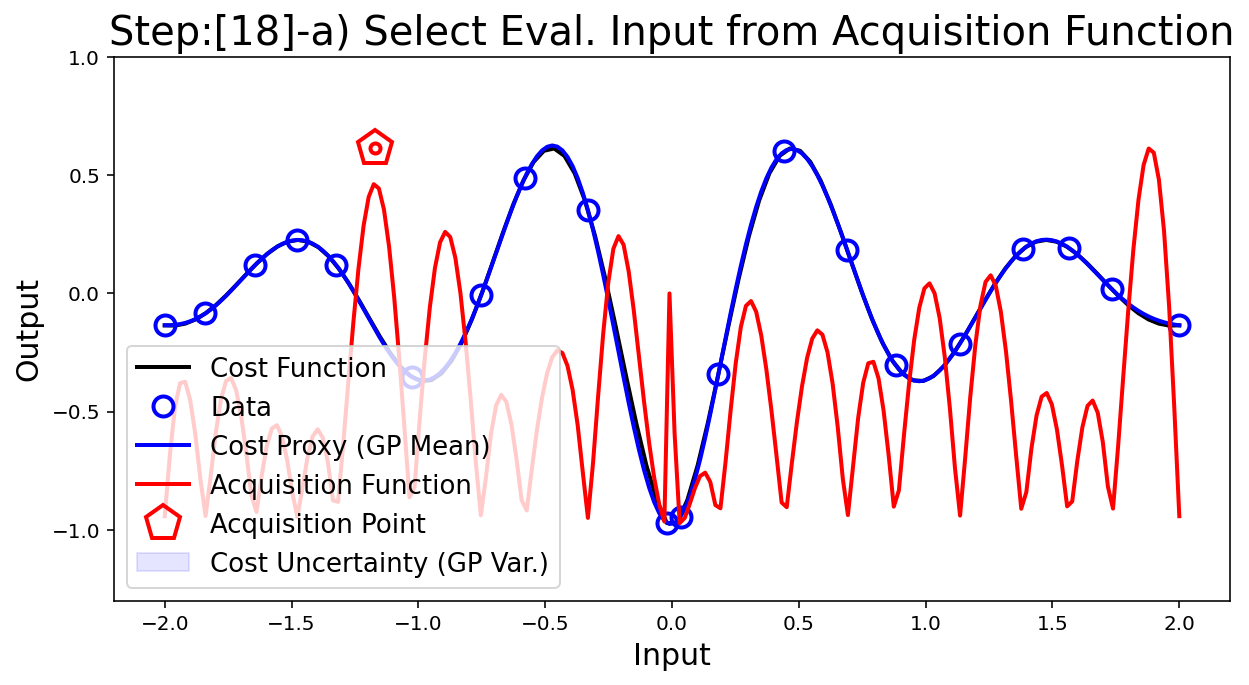

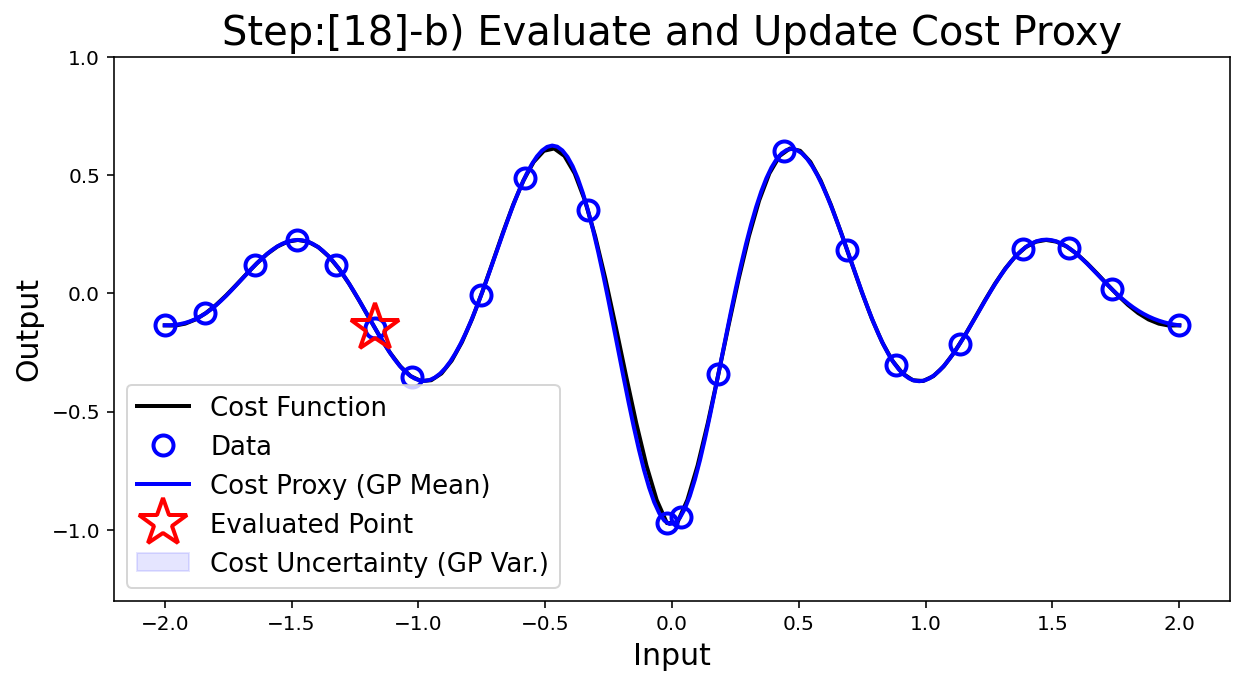

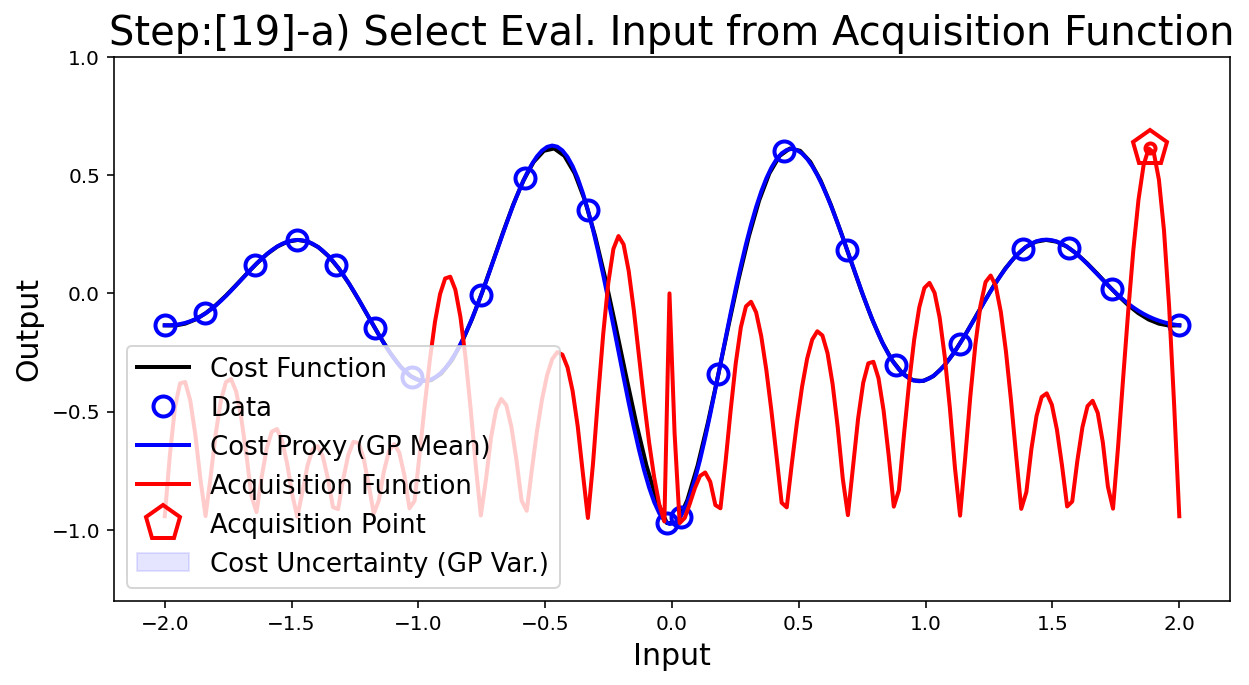

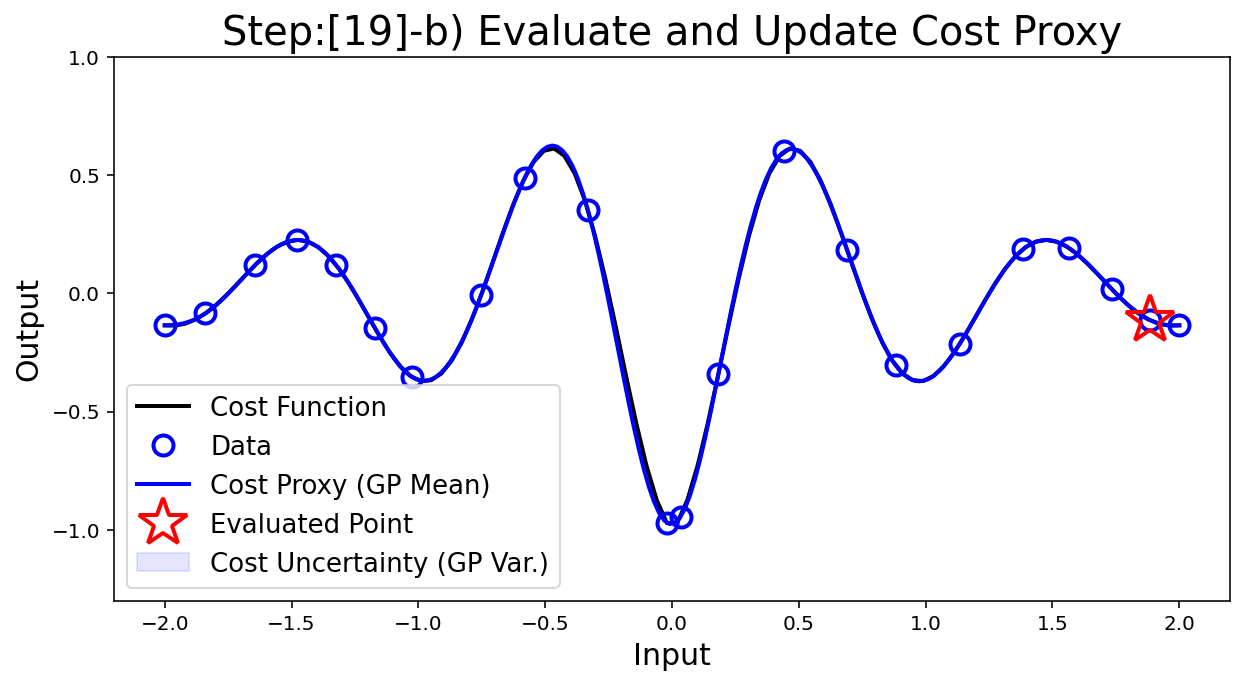

Done.


In [5]:
np.random.seed(seed=seed) # fix random seed 
xdim = x_minmax.shape[0]
x_data,y_data = np.zeros((0,xdim)),np.zeros((0,1))

# Random sampling
x_evals = x_sampler(n_sample=2,x_minmax=x_minmax)
y_evals = [func_eval(x=x_eval) for x_eval in x_evals] 
x_data = np.concatenate((x_data,np.asarray(x_evals)[:,0,:]),axis=0)
y_data = np.concatenate((y_data,np.asarray(y_evals)[:,0,:]),axis=0)
plot_line(
    x_target,y_target,fmt='-',lc='k',lw=2,label='Cost Function',
    x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
    figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Random Sampling',tfs=20,
    ylim=[-1.3,+1],
    lfs=13,lloc='lower left')

for it in range(max_step):
    
    # Bayesian Optimization
    invlen,eps = 5.0,1e-10
    x_test = np.linspace(start=xmin,stop=xmax,num=200).reshape((-1,1))
    a_ei,mu_test,var_test = acquisition_function(
        x_data,y_data,x_test,x_minmax=x_minmax,SCALE_Y=True,gain=1.0,invlen=invlen,eps=eps)
    a_ei = scale_to_match_range(x_to_change=a_ei,y_to_refer=y_target) # scale acquisition
    max_idx = np.argmax(a_ei)  
    x_bo = x_test[max_idx,:].reshape((1,-1)) # find the maxima
    y_ei = a_ei[max_idx,0] # acquisition function 
    
    # Find the maxima of the acquisition function using optimization with multiple restarts
    x_bo = argmax_acquisition(x_data,y_data,x_minmax,
                              n_retry=10,kgain=1.0,invlen=invlen,eps=eps,maxiter=100,n_cd_step_per_dim=0)
    
    
    if it is 0:
        plot_line(
            x_target,y_target,fmt='-',lc='k',lw=2,label='Cost Function',
            x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
            x3=x_test,y3=mu_test,fmt3='-',lc3='b',label3='Cost Proxy (GP Mean)',
            x_fb=x_test,y_fb_low=mu_test-var_test,y_fb_high=mu_test+var_test,fba=0.1,fbc='b',labelfb='Cost Uncertainty (GP Var.)',
            figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Update Cost Proxy using GP',tfs=20,
            ylim=[-1.3,+1],
            lfs=13,lloc='lower left')
    
    # Select Eval. Input from Acquisition Function
    plot_line(
        x_target,y_target,fmt='-',lc='k',lw=2,label='Cost Function',
        x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
        x3=x_test,y3=mu_test,fmt3='-',lc3='b',lw3=2,label3='Cost Proxy (GP Mean)',
        x_fb=x_test,y_fb_low=mu_test-var_test,y_fb_high=mu_test+var_test,fba=0.1,fbc='b',labelfb='Cost Uncertainty (GP Var.)',
        x4=x_test,y4=a_ei,fmt4='-',lc4='r',label4='Acquisition Function',
        x5=x_bo,y5=y_ei,fmt5='p',lc5='r',lw5=2,ms5=18,mew5=2,label5='Acquisition Point',
        x6=x_bo,y6=y_ei,fmt6='o',lc6='r',lw6=2,ms6=5,mew6=2,label6=None,
        figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,
        tstr='Step:[%d]-a) Select Eval. Input from Acquisition Function'%(it),tfs=20,
        ylim=[-1.3,+1],
        lfs=13,lloc='lower left')
    
    # Evaluate the point selected from BO and update the acquisition function 
    y_bo = func_eval(x_bo)
    x_data = np.concatenate((x_data,x_bo),axis=0)
    y_data = np.concatenate((y_data,y_bo),axis=0)
    a_ei,mu_test,var_test = acquisition_function(
        x_data,y_data,x_test,x_minmax=x_minmax,SCALE_Y=True,gain=1.0,invlen=invlen,eps=eps)
    a_ei = scale_to_match_range(x_to_change=a_ei,y_to_refer=y_target)
    
    # Evaluate and Update the Target Proxy
    plot_line(
        x_target,y_target,fmt='-',lc='k',lw=2,label='Cost Function',
        x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
        x3=x_test,y3=mu_test,fmt3='-',lc3='b',lw3=2,label3='Cost Proxy (GP Mean)',
        x_fb=x_test,y_fb_low=mu_test-var_test,y_fb_high=mu_test+var_test,fba=0.1,fbc='b',labelfb='Cost Uncertainty (GP Var.)',
        x5=x_bo,y5=y_bo,fmt5='*',lc5='r',lw5=2,ms5=25,mew5=2,label5='Evaluated Point',
        figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,
        tstr='Step:[%d]-b) Evaluate and Update Cost Proxy'%(it),tfs=20,
        ylim=[-1.3,+1],
        lfs=13,lloc='lower left')
    
print ("Done.")